# Building an Uncertainty-Aware MNIST Digit Classifier using Cirkit


## Goals

By the end of this tutorial you will:

* Know how to build a multi-class classifier using cirkit
* Understand how to train the model generatively and discriminatively
* Understand how to easily produce variants of your classifier


In this notebook we will loosely follow the [RAT SPN paper](https://proceedings.mlr.press/v115/peharz20a/peharz20a.pdf).
For the paper, the authors had to implement all the circuit operations from scratch in tensorflow, because Cirkit did not exist!

### Enter Cirkit &#x1F50C; &#x26A1;	
Cirkit's modularity makes building circuits like those used in the RAT SPN paper extremely easy.
We will show this by:

1. Reimplementing the MNIST experiments of the RAT SPN paper with just a few lines of code
2. Illustrating how to easily adapt/improve models with plug & play modules

# Load Image Data  &#x1F5BC;	&#x1F5B4;

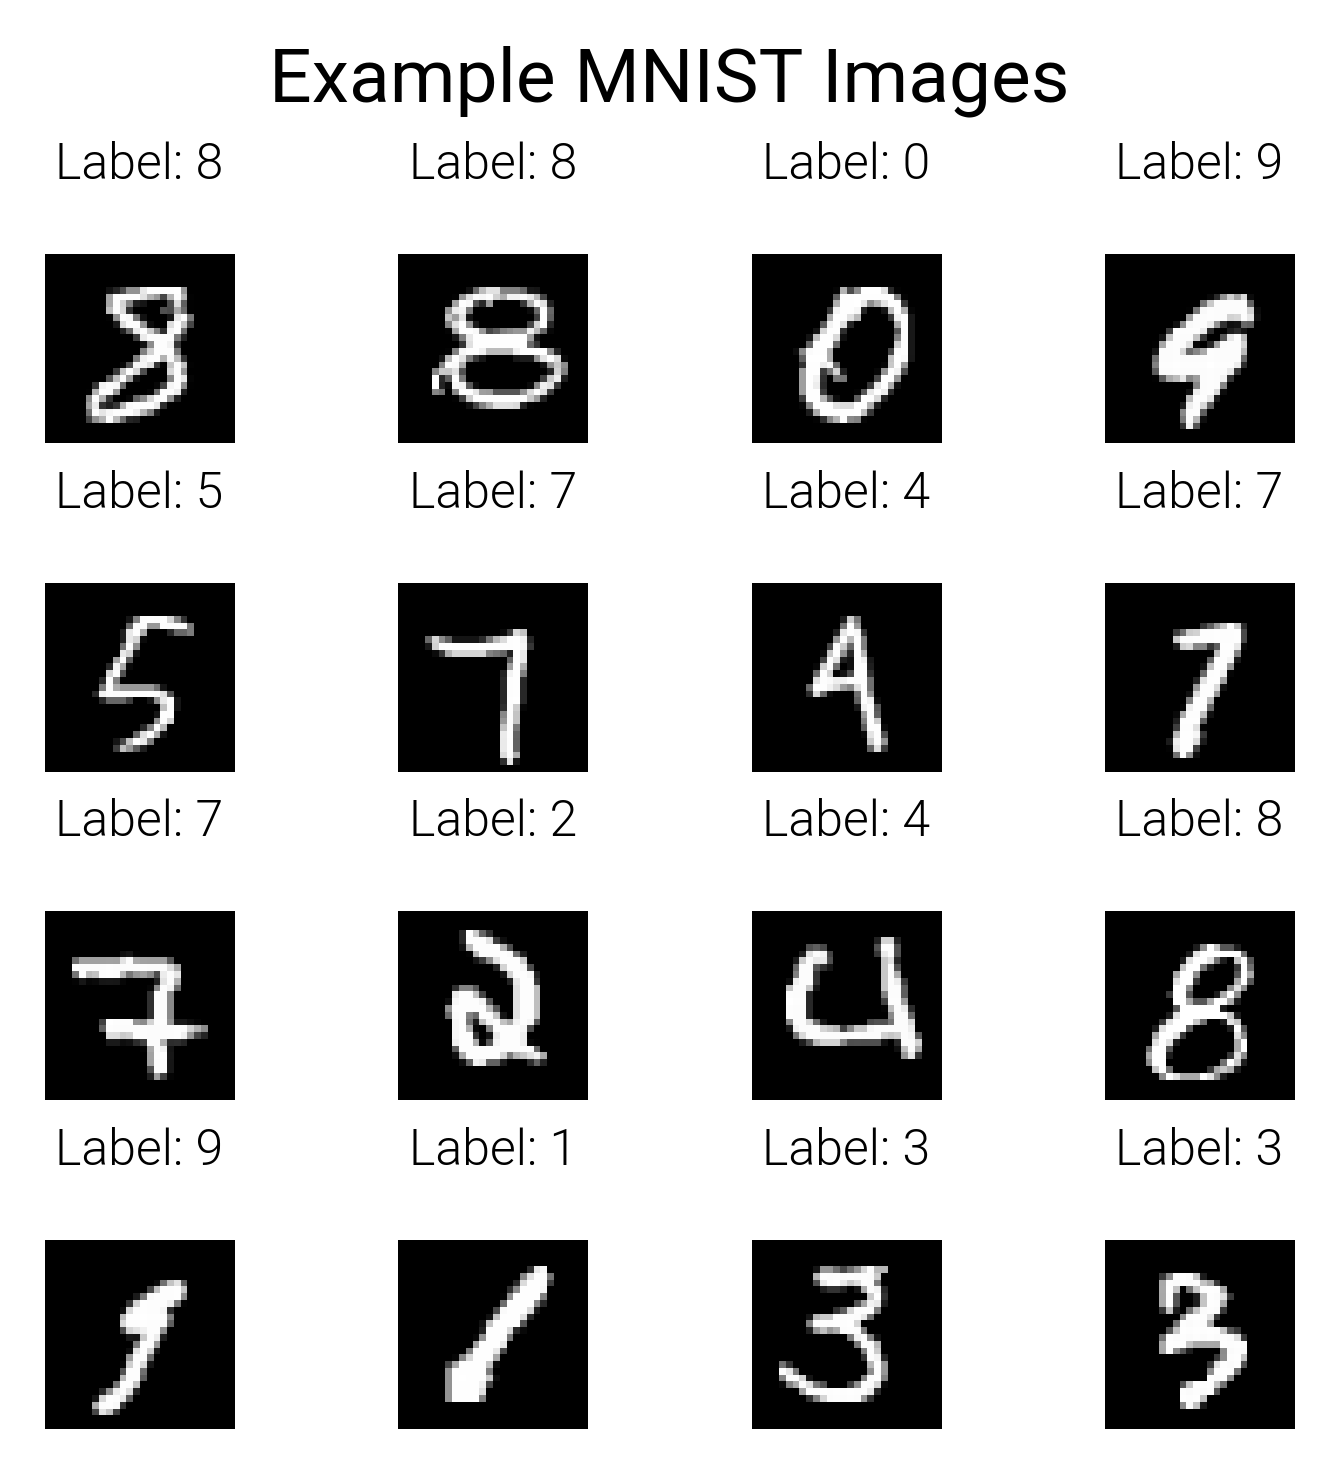

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import transforms, datasets


PIXEL_RANGE= 255
IMAGE_SIZE = [28, 28]
NUM_PIXELS_IN_IMAGE = np.prod(IMAGE_SIZE)

NUM_CLASSES = 10 # Number of digits in MNIST

# Store an example image
example_image = None

# Load the MNIST data set and data loaders
transform = transforms.Compose([
    transforms.ToTensor(),
    # Set pixel values in the [0-255] range
    transforms.Lambda(lambda x: {'images': (PIXEL_RANGE * x).long()})
])

# Function to plot the first 9 images from the dataloader
def plot_sample_images(dataloader, gridsize=4):
    global example_image
    # Get the first batch of images and labels
    inputs, labels = next(iter(dataloader))
    
    example_image = inputs['images'][0]
    images = inputs['images'][:gridsize**2]
    
    # Create a 3x3 subplot
    fig, axes = plt.subplots(gridsize, gridsize, figsize=(8, 8))
    
    # Plot each image
    for i, ax in enumerate(axes.flat):
        # Convert the image to a 2D array (since MNIST images are 28x28 pixels)
        img = images[i].numpy().squeeze()

        # Display the image
        ax.imshow(img, cmap='gray')
        ax.axis('off')  # Turn off axis
        ax.set_title(f"Label: {labels[i].item()}", fontsize=20)
    
    # Adjust spacing between subplots
    fig.suptitle('Example MNIST Images', fontsize=30)
    plt.tight_layout()
    plt.show()


data_train = datasets.MNIST('datasets', train=True, download=True, transform=transform)
data_test = datasets.MNIST('datasets', train=False, download=True, transform=transform)

# Instantiate the training and testing data loaders
train_dataloader = DataLoader(data_train, shuffle=True, batch_size=256)
test_dataloader = DataLoader(data_test, shuffle=False, batch_size=256)

# Call the function to plot images
plot_sample_images(train_dataloader, gridsize=4)

# Building a Digit Classifier using Cirkit &#x1F50C;

In this section, we show how to train our circuit such that it can classify MNIST digits.
We will show 3 ways of training:

1. Generative Training
2. Discriminative Training
3. Combination of Both (i.e. using a multi-task objective)

### Notation

* $\mathbf{x}$ are the pixels of an image
* $y$ is the MNIST digit class, i.e. $y \in \{0,\ldots,9\}$
* $N$ is the number of training examples

## 1. Generative Training Objective (LL)

### Modelling $P(\mathbf{x})$ directly
We have [already seen](https://github.com/april-tools/cirkit/blob/main/notebooks/learning-a-circuit.ipynb) how we can fit a circuit to estimate the distribution of our MNIST images, i.e. $P(\mathbf{x})$. 
However, fitting the model this way is no good for a digit **classifier** because the model does not include a random variable for the digit class.
**What if we also want to model the class of each image?**

### Modelling $P(\mathbf{x})$ by also including the digit class, i.e. $P(\mathbf{x} \mid y)$.

In order to include the class image in our model, we can fit $P(\mathbf{x} \mid y)$ for $y \in \{ 0 \ldots 9 \}$.
We can then obtain $P(\mathbf{x})$ by marginalising out $y$:

$$
P(x) = \sum_{y} P(\mathbf{x} \mid y) P(y)
$$

**But how do we construct a circuit to give us the conditional distributions $P(\mathbf{x} \mid y)$?**
### Estimating $P(\mathbf{x} \mid y)$ for $y \in \{ 0\ldots 9 \}$
Recall that when we were modelling $P(\mathbf{x})$ directly, our circuit had a single log-probability output, which we interpreted as $\log P(\mathbf{x})$.
In our case, we could instead fit $10$ separate circuits, one per image class. However, this is wasteful.
Images have shared characteristics that all $10$ circuits would have to re-learn from scratch, separately.
Can we do better?


### Parameter Sharing
Yes! We can use **parameter sharing**, i.e., we can share the early layers of our circuit and only adapt the output layer to produce our conditional distributions.
Since there are $10$ classes, we change the last layer of our circuit to output $10$ log-probabilities: the probability mass over images for each class, $P(\mathbf{x} \mid y)$.
We can do so by specifying the `num_classes` option in `Circuit.from_region_graph`.

As in our earlier notebooks, we have a choice for the region graph and input parametrisations.
We use a similar setup as previous notebooks, but we change the `num_classes` argument to be 10 and use 3 repetitions of RandomBinaryTrees to [mimic the RAT SPN paper](https://proceedings.mlr.press/v115/peharz20a/peharz20a-supp.pdf).

In [2]:
from cirkit.symbolic.circuit import Circuit
from cirkit.templates.region_graph import RandomBinaryTree, RegionGraph
from cirkit.symbolic.layers import CategoricalLayer
from cirkit.templates.circuit_templates.utils import Parameterization, parameterization_to_factory
from cirkit.templates.region_graph import QuadGraph, QuadTree


NUM_INPUT_UNITS = 64
NUM_SUM_UNITS = 64


def build_class_conditional_circuit(num_classes: int,
                                    rg: RegionGraph,
                                    sum_prod_layer: str = 'cp') -> Circuit:
    input_factory = lambda scope, y, z: CategoricalLayer(
        scope=scope,
        num_categories=PIXEL_RANGE+1,
        num_channels=1, # These are grayscale images
        num_output_units=NUM_INPUT_UNITS # Overparameteribzation
    )

    # Note that below intialisation is needed
    sum_weight_param = Parameterization(activation='softmax', initialization='normal')
    sum_weight_factory = parameterization_to_factory(sum_weight_param)
    
    circuit = Circuit.from_region_graph(
        rg,
        input_factory=input_factory,
        sum_weight_factory= sum_weight_factory,
        num_sum_units=NUM_SUM_UNITS,
        sum_product=sum_prod_layer,
        num_classes=num_classes,     # <- This line makes our circuit have num_classes outputs
    )
    return circuit


rg = RandomBinaryTree(NUM_PIXELS_IN_IMAGE, depth=None, num_repetitions=3)
circuit = build_class_conditional_circuit(NUM_CLASSES, rg, 'cp')

## Estimating $P(\mathbf{x})$


Now that we have a circuit that can compute $P(\mathbf{x} \mid y)$, let's compute $P(\mathbf{x})$ via marginalisation:

$$
P(x) = \sum_{y} P(\mathbf{x} \mid y) P(y)
$$


### Working with $\log$ Probabilities

For numerical reasons our circuits output log probabilities. We can rewrite the above equation as:

$$
\log P(x) = \log \sum_{y} P(\mathbf{x} \mid y) P(y)
$$

Since our circuit outputs log probabilities, in order to compute the sum on the right we use a `logsumexp` operation, as can be seen on the highlighted line below:


### Generative Loss in Code
```python
def generative_loss(log_probs, labels, marginalize=True, prior=None):
    batch_size, num_classes = log_probs.shape

    if marginalize:
        # Set prior to uniform if not set
        prior = prior or torch.ones(num_classes, device=log_probs.device) / num_classes
        #             ====  LOGSUMEXP ====
        d_log_probs = torch.logsumexp(log_probs + torch.log(prior), dim=1)
    else:
        # Select the logprob given by y - i.e. the true label
        d_log_probs = log_probs[torch.arange(batch_size), labels]
    # Compute average over examples (1/N)
    # Negative since max log likelihood = min negative log likelihood
    return -torch.mean(d_log_probs)
```


## 2. Discriminative Training Objective  (CE)

Ok, so we have a model that can generate images while taking the image class into account. But if we want to build a classifier, we need to model $P(y \mid \mathbf{x})$.


### Using Bayes' rule to convert our Generator into a Classifier

We can use Bayes' rule to flip $P(\mathbf{x} \mid y)$ to our required $P(y \mid \mathbf{x})$.

$$P(y \mid \mathbf{x}) = \frac{P(\mathbf{x} \mid y)P(y)}{\sum_y P(\mathbf{x} \mid y)P(y)}$$

### Uniform Prior $P(y)$
While we could estimate $P(y)$ empirically, we assume a uniform prior here for simplicity. Doing so allows us to simplify the above expression to:

$$P(y \mid \mathbf{x}) = \frac{P(\mathbf{x} \mid y)}{\sum_y P(\mathbf{x} \mid y)}$$

### Working with $\log$ Probabilities

As a last step, for numerical reasons our circuit outputs log probabilities, so we rewrite the above in terms of log probabilities as:

$$\log P(y \mid \mathbf{x}) = \log P(\mathbf{x} \mid y) - \log \sum_y P(\mathbf{x} \mid y)$$

Since our circuit outputs log probabilities, in order to compute the sum on the right we use a `logsumexp` operation.

Great, so we can now estimate the probability of an image class given an image! What's more, we can train using this discriminative loss:

### Discriminative Loss in Code
```python
def discriminative_loss(log_probs, labels):
    batch_size, num_classes = log_probs.shape
    # Select log P(x | y) where y is the true label
    target_log_prob = log_probs[torch.arange(batch_size), labels]
    # Compute log P(y | x)
    d_log_probs = target_log_prob - torch.logsumexp(log_probs, dim=1)
    return -torch.mean(d_log_probs)
```

## 3. Combining Both Objectives

<div style="max-width:25%; margin: auto;">

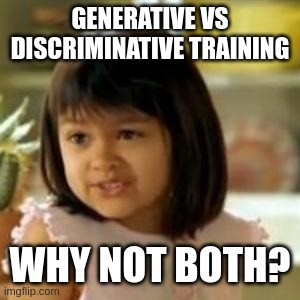

</div>

The RAT SPN papepr also considers training using a trade-off between the two objectives.
To do so, it introduces a parameter $\lambda \in [0, 1]$ and computes a combined loss as:

<div style="max-width:45%; margin: auto;">
    
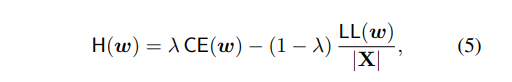

</div>

* $\lambda = 0  \rightarrow$ Model trained only generatively
* $\lambda = 1  \rightarrow$ Model trained only contrastively
* $\lambda \in (0, 1) \rightarrow$ trade-off between losses

### Losses on different scale
Note that the generative (NLL) and discriminative (CE) losses are on different scales, primarily because they are defined on a different number of random variables.
CE is defined over a single random variable, $y$, while NLL is defined over $28 \times 28=784$ pixels.
To make the interpolation more reasonable, we therefore divide the NLL loss by $|X|$, i.e. $784$ in our case.


### Both Objectives in Code
Below we put everything together in the `MNISTClassifier` class.

In [5]:
from collections import defaultdict

from cirkit.backend.torch.queries import IntegrateQuery
from cirkit.utils.scope import Scope
from cirkit.pipeline import compile


print_every = 100
# Set the torch device to use
device = torch.device('cpu')


class MNISTClassifier(object):

    """A class that implements class conditional classifiers for circuits.
    It includes helper functions for computing generative and discriminative
    loss and interpolating between the two."""

    def __init__(self, model, interpolation=.5, scale_gen=1., scale_dis=1.):
        self.model = model
        self.marginal_query = IntegrateQuery(self.model)
        assert 0 <= interpolation <= 1
        self.interpolation = interpolation
        self.scale_gen = scale_gen
        self.scale_dis = scale_dis

    def __call__(self, **kwargs):

        xx = kwargs['images']
        yy = kwargs['labels']
        mm = kwargs.get('masks', None)

        assert xx.shape[0] == yy.shape[0]
        
        if mm is None:
            log_probs = self.model(xx)
        else:
            assert xx.shape[0] == len(mm)
            log_probs = self.marginal_query(xx, integrate_vars=[Scope(list(mask)) for mask in mm])            

        batch_size, num_channels, num_classes = log_probs.shape
        assert num_channels == 1
        assert num_classes > 1

        # Remove channel dim (which is one)
        log_probs = log_probs.squeeze(dim=1)

        gen_loss = self.generative_loss(log_probs, yy, marginalize=True)
        dis_loss = self.discriminative_loss(log_probs, yy)

        # lambda * CE(w) - (1-lambda) LL(w)
        loss = self.interpolation * dis_loss * self.scale_dis + (1 - self.interpolation) * gen_loss * self.scale_gen

        probs = torch.exp(log_probs - torch.logsumexp(log_probs, dim=1, keepdims=True))

        image_log_probs = self.image_log_probs(log_probs)

        return dict(loss=loss,
                    probs=probs,
                    image_log_probs=image_log_probs,
                    gen_loss=gen_loss,
                    dis_loss=dis_loss)
    
    @staticmethod
    def image_log_probs(log_probs, prior=None):
        # Compute P(x) by marginalising out y, i.e. sum_i P(x|y)P(y)
        # Set prior to uniform if not set
        batch_size, num_classes = log_probs.shape
        
        prior = prior or torch.ones(num_classes, device=log_probs.device) / num_classes
        d_log_probs = torch.logsumexp(log_probs + torch.log(prior), dim=1)
        return d_log_probs

    @staticmethod
    def cond_image_log_probs(log_probs, labels):
        # Compute conditional probability P(x|y) where y is the known class of the image
        batch_size, num_classes = log_probs.shape
        
        d_log_probs = log_probs[torch.arange(batch_size), labels]
        return d_log_probs
        
    @staticmethod
    def generative_loss(log_probs, labels, marginalize=True, prior=None):
        if marginalize:
            d_log_probs = MNISTClassifier.image_log_probs(log_probs, prior=prior)
        else:
            # Select the logprob given by y - i.e. the true label
            d_log_probs = MNISTClassifier.cond_image_log_probs(log_probs, labels)
        return -torch.mean(d_log_probs)

    @staticmethod
    def discriminative_loss(log_probs, labels):
        batch_size, num_classes = log_probs.shape
        # Select log P(x | y) where y is the true label
        target_log_prob = log_probs[torch.arange(batch_size), labels]
        # Compute log P(y | x)
        d_log_probs = target_log_prob - torch.logsumexp(log_probs, dim=1)
        return -torch.mean(d_log_probs)


def train_model(circuit, dataloader, interpolation=.5):
    # Set some seeds
    np.random.seed(42)
    torch.manual_seed(42)
    
    
    cc = compile(circuit)
    # Move the circuit to chosen device
    cc = cc.to(device)
    cc.train()
    
    
    model = MNISTClassifier(cc,
                            interpolation=interpolation,
                            scale_gen=1./NUM_PIXELS_IN_IMAGE,
                            scale_dis=1.)
    
    num_epochs = 2
    step_idx = 0
    stats, step_stats = defaultdict(list), defaultdict(float)
    
    # Initialize a torch optimizer of your choice,
    #  e.g., Adam, by passing the parameters of the circuit
    optimizer = torch.optim.Adam(cc.parameters(), lr=0.01)
    
    
    for epoch_idx in range(num_epochs):
        for i, ((inputs), labels) in enumerate(dataloader):
            # The circuit expects an input of shape (batch_dim, num_channels, num_variables),
            # so we unsqueeze a dimension for the channel.
            BS = labels.shape[0]
            
            images = inputs['images'].view(BS, 1, -1).to(device)
            labels = labels.view(BS).to(device)
            masks = inputs.get('masks', None)
            
            result = model(images=images, labels=labels, masks=masks)
            
            loss = result['loss']
            loss.backward()
    
            # Update the parameters of the circuits, as any other model in PyTorch
            optimizer.step()
            optimizer.zero_grad()
    
            # Get digit probabilities
            probs = result['probs']
            # Predict the digit with the largest probability
            preds = torch.argmax(probs, dim=1)
            acc = torch.mean((preds == labels).float())
            
            step_stats['loss'] += loss.detach().item() * BS
            step_stats['accuracy'] += acc.detach().item() * BS
            step_stats['gen_loss'] += result['gen_loss'].detach().item() * BS
            step_stats['dis_loss'] += result['dis_loss'].detach().item() * BS


            step_idx += 1
            if step_idx % print_every == 0:
                for k, v in step_stats.items():
                    step_stats[k] = step_stats[k] / (print_every * BS)
                print(f"Step {step_idx}: Average Loss: {step_stats['loss']:.3f}: Average Accuracy: {step_stats['accuracy'] * 100:.2f}%")

                for k, v in step_stats.items():
                    stats['train_%s' % k].append(v)

                step_stats = defaultdict(float)

    return model, stats

models, stats = dict(), dict()
# Train models with different interpolation
# for lamda in [0., .25, .5, .75, 1.]:
for lamda in [.5]:
    model_name = 'RandomBinaryTree $\\lambda=$%.2f' % lamda
    rg = RandomBinaryTree(NUM_PIXELS_IN_IMAGE, depth=None, num_repetitions=3)
    circuit = build_class_conditional_circuit(NUM_CLASSES, rg, 'cp')
    models[model_name], stats[model_name] = train_model(circuit, train_dataloader, interpolation=lamda)

Step 100: Average Loss: 3.791: Average Accuracy: 10.05%
Step 200: Average Loss: 3.295: Average Accuracy: 11.21%
Step 300: Average Loss: 1.904: Average Accuracy: 36.02%
Step 400: Average Loss: 1.051: Average Accuracy: 74.68%


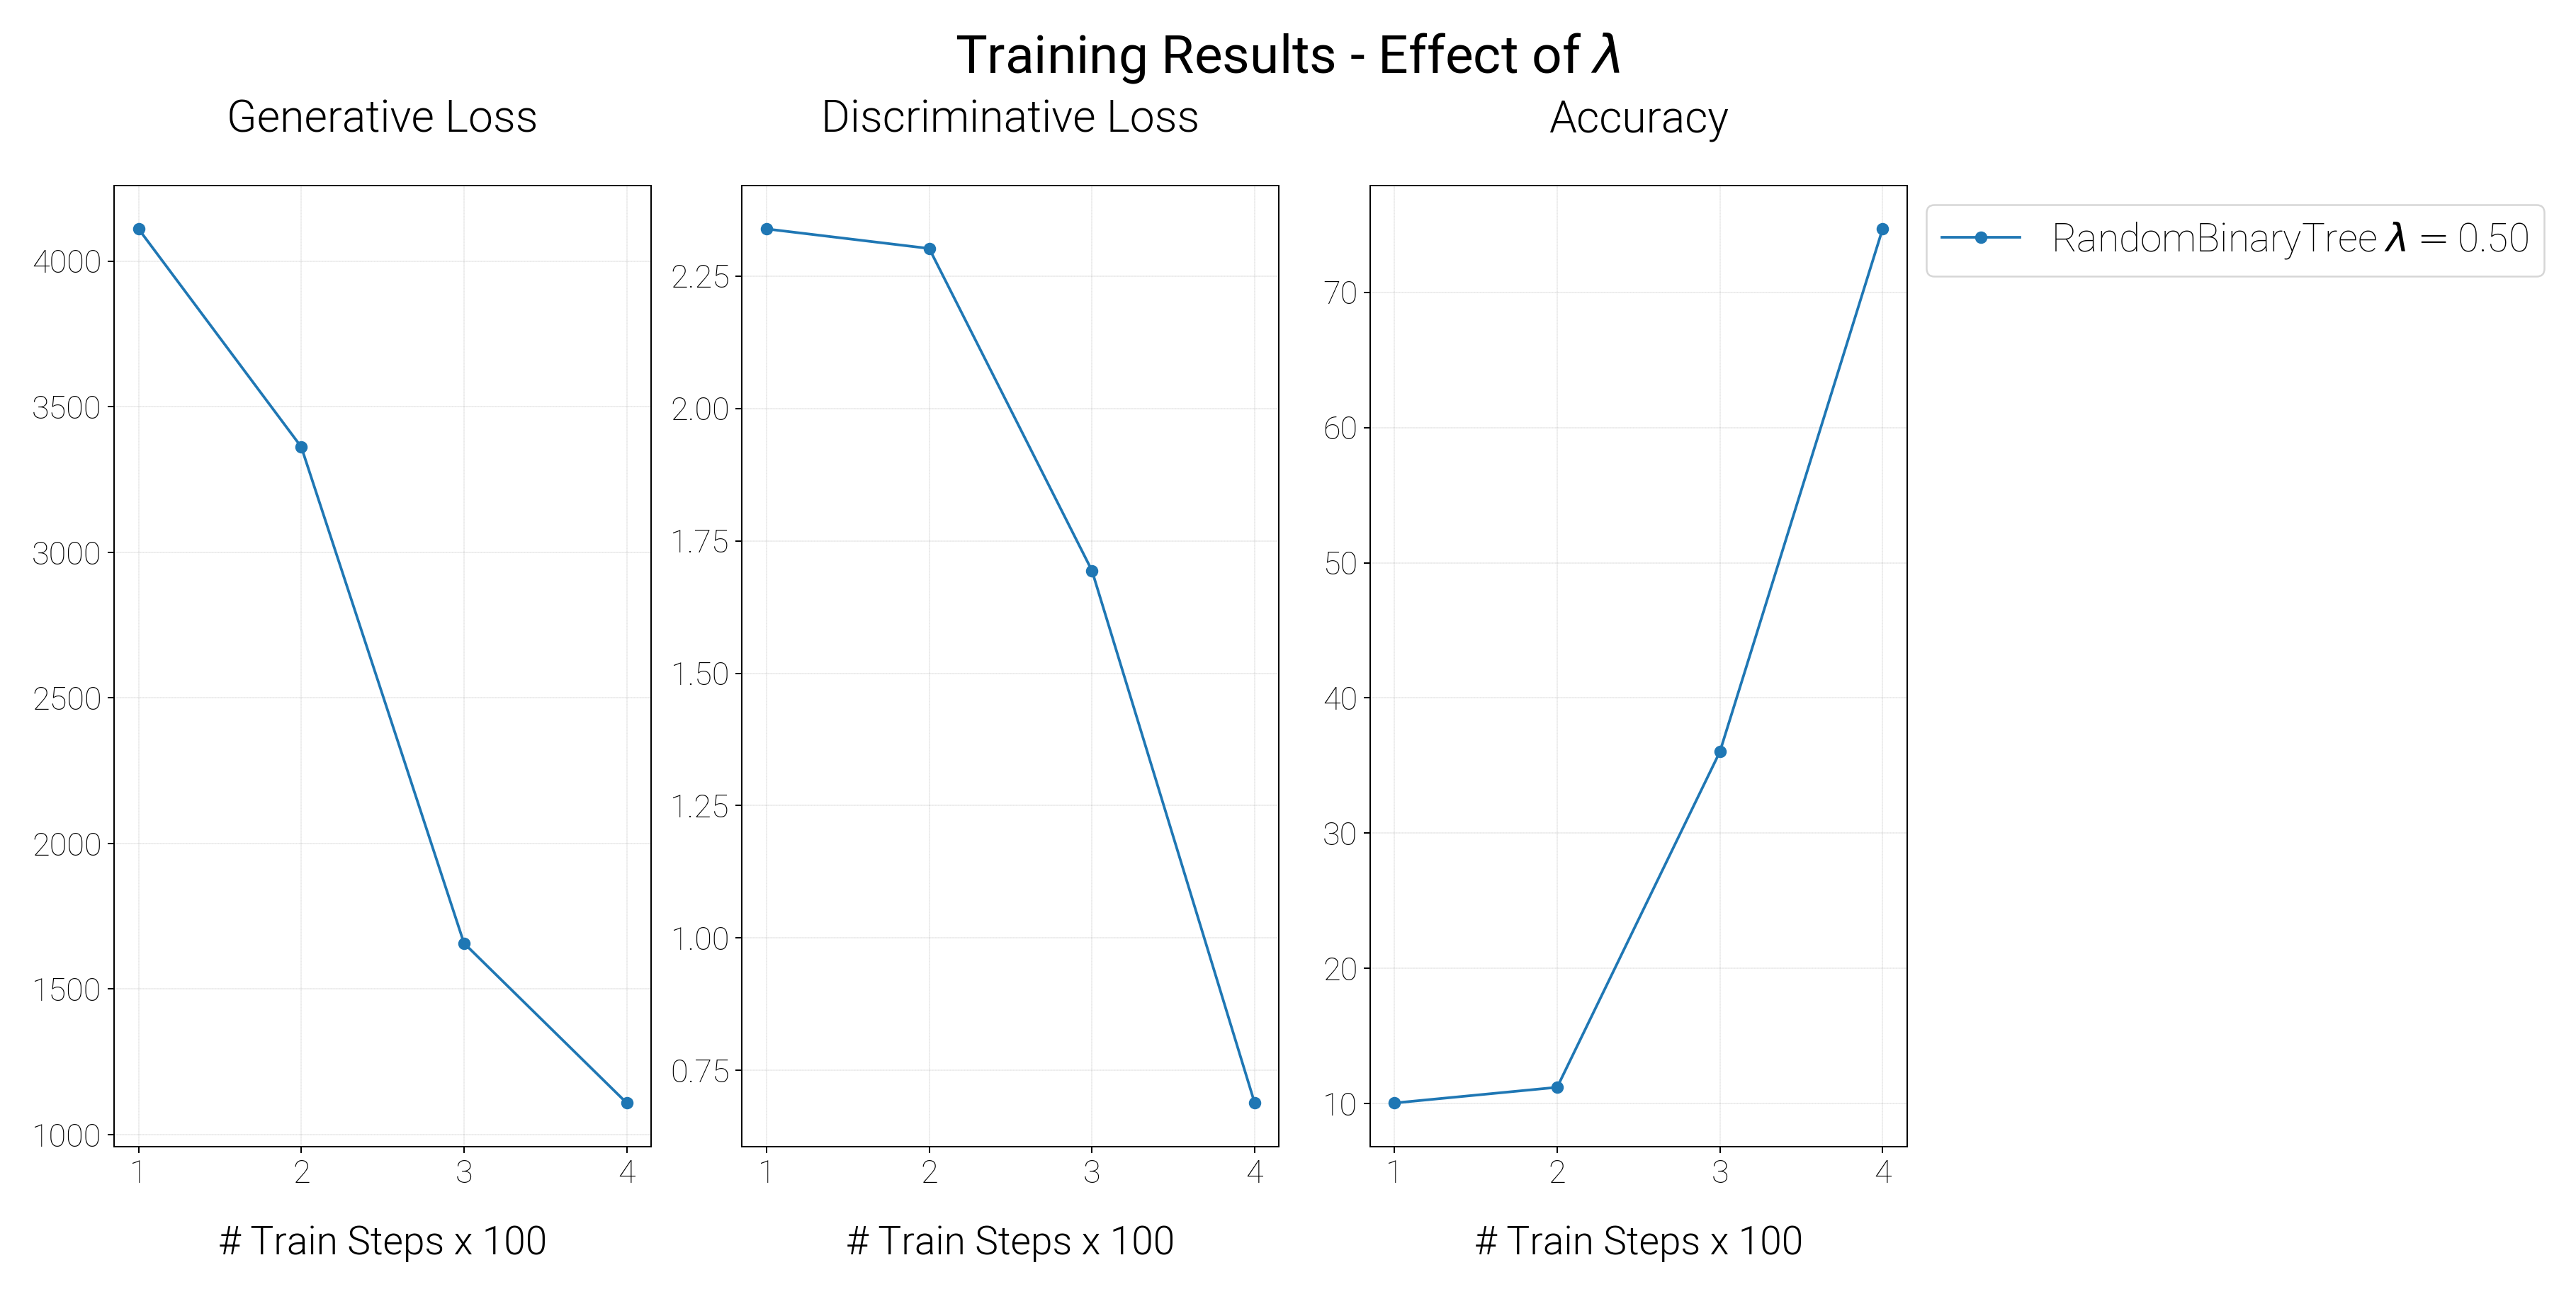

In [7]:
def plot_train_stats(stats):
    # Plot figures of results
    fig, axes = plt.subplots(figsize=(20, 10), ncols=3)
    for k, v in stats.items():
        xx = np.arange(1, len(v['train_gen_loss'])+1)
        lbl = k.replace('lambda ', '$\\lambda$=')
        axes[0].plot(xx, v['train_gen_loss'], '-o', label=lbl)
        axes[1].plot(xx, v['train_dis_loss'], '-o', label=lbl)
        axes[2].plot(xx,[a * 100 for a in v['train_accuracy']], '-o', label=lbl)
    
    axes[0].set_title('Generative Loss')
    axes[1].set_title('Discriminative Loss')
    axes[2].set_title('Accuracy')
    axes[0].set_xlabel('# Train Steps x %d' % print_every)
    axes[1].set_xlabel('# Train Steps x %d' % print_every)
    axes[2].set_xlabel('# Train Steps x %d' % print_every)
    
    plt.suptitle('Training Results - Effect of $\\lambda$', fontsize=30)
    plt.legend(bbox_to_anchor=(1., 1.), fontsize=22)
    plt.tight_layout()
    plt.show()


plot_train_stats(stats)

In [8]:
import pandas as pd


def test_model(classifier, dataloader):
    stats = defaultdict(float)
    
    with torch.no_grad():
        test_lls = 0.0
        classifier.model.eval()

        N = 0
        for inputs, labels in dataloader:

            BS = labels.shape[0]
            
            images = inputs['images'].view(BS, 1, -1).to(device)
            labels = labels.view(BS).to(device)
            masks = inputs.get('masks', None)
            
            # Compute the log-likelihoods of the batch, by evaluating the circuit
            result = classifier(images=images, labels=labels, masks=masks)

            # Get digit probabilities
            probs = result['probs']
            # Predict the digit with the largest probability
            preds = torch.argmax(probs, dim=1)
            acc = torch.mean((preds == labels).float())

            stats['test accuracy'] += acc.detach().item() * BS
            stats['test gen loss'] += result['gen_loss'].detach().item() * BS
            stats['test dis loss'] += result['dis_loss'].detach().item() * BS
    
            N += BS
    
        # Compute average test log-likelihood and bits per dimension
        for k, v in stats.items():
            stats[k] = stats[k] / N

        stats['test bpd'] = stats['test gen loss'] / (NUM_PIXELS_IN_IMAGE * np.log(2.0))
    return stats

test_stats = dict()
for k, model in models.items():
    test_stats[k] = test_model(model, test_dataloader)

df = pd.DataFrame.from_dict(test_stats, orient='index')
df

,test accuracy,test gen loss,test dis loss,test bpd
RandomBinaryTree $\lambda=$0.50,0.8673,1014.183569,0.419794,1.866272


# Tolerance to Dropped Pixels via Marginalisation


## Data with missing inputs
Sometimes we need to model data with missing inputs!


## Example

Let's visualise what it looks like to drop $p\%$ of the pixels from an image, dropped pixels shown in orange below for $p \in [10, 25, 50, 75]$.

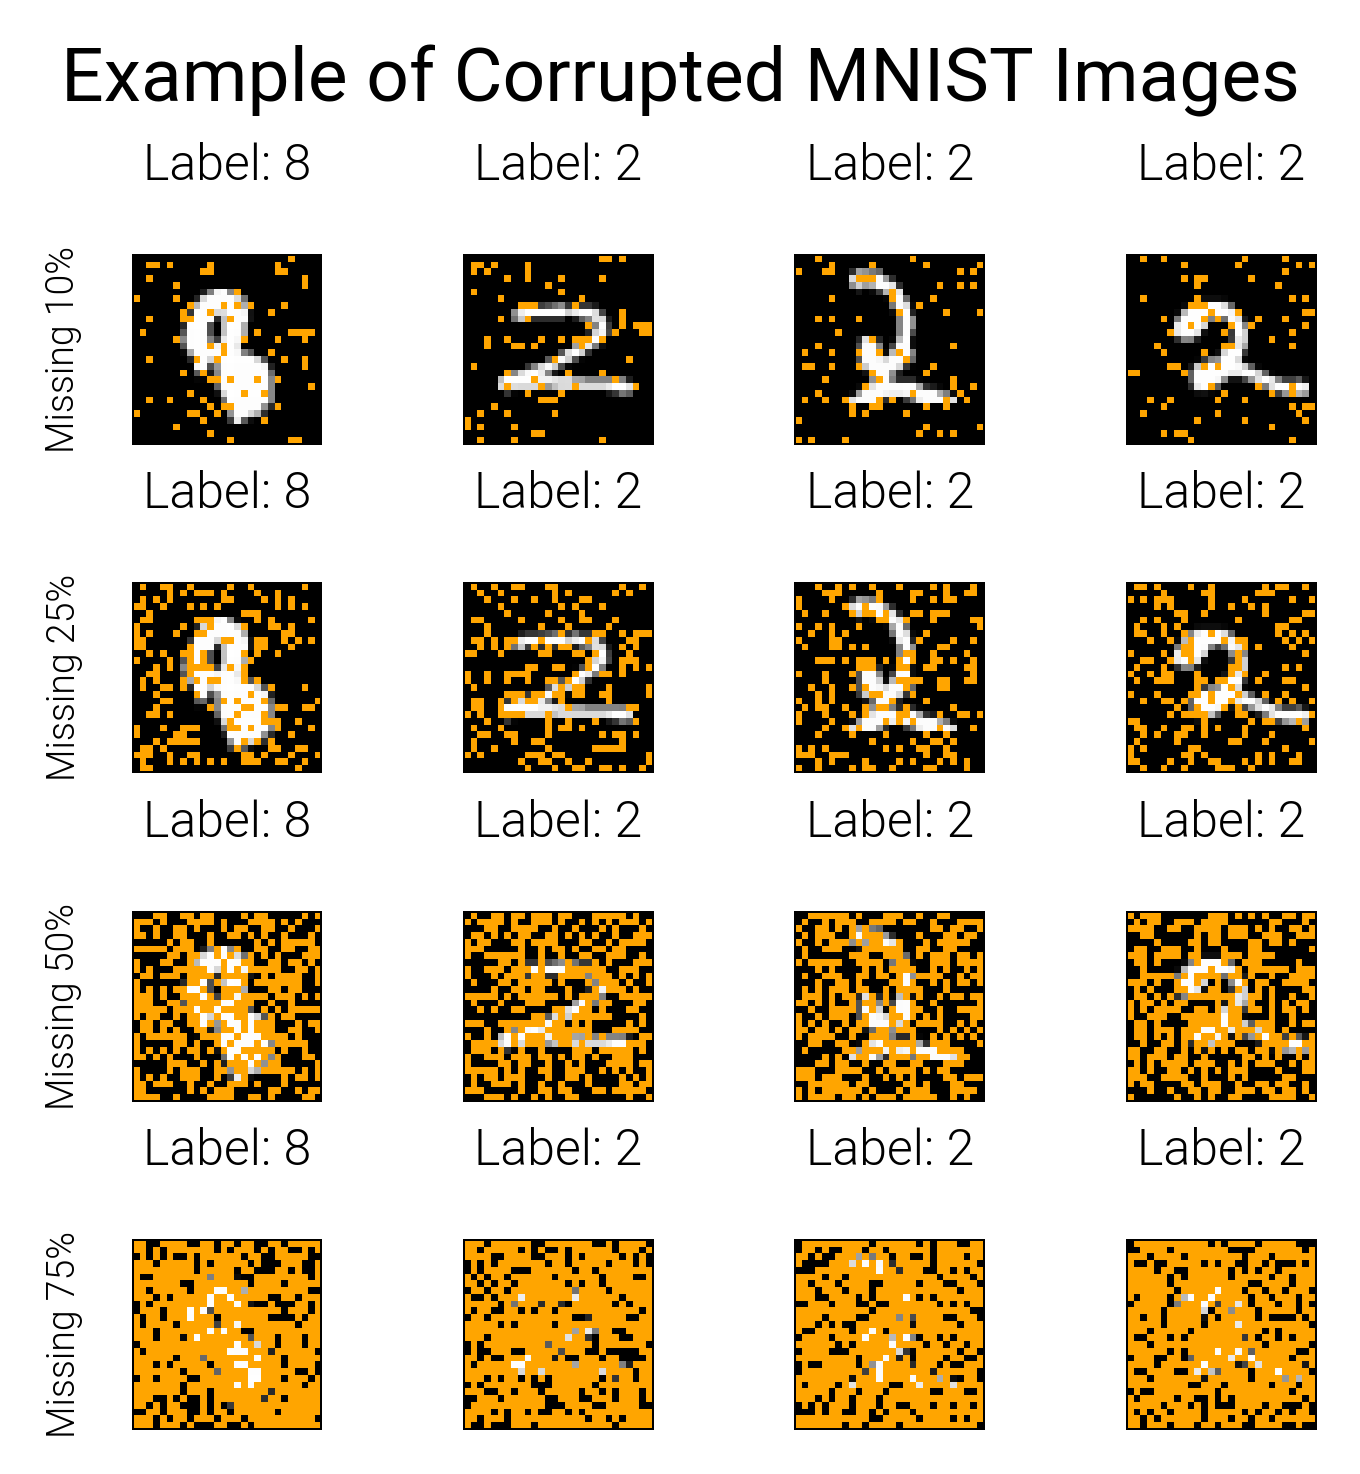

In [9]:
def sample_masks(image_size, num_images, p=.5):
    num_pixels = np.prod(image_size)
    num_samples = int(p*num_pixels)
    masks = [list(np.random.choice(range(np.prod(image_size)), size=num_samples, replace=False))
             for i in range(num_images)]
    return masks


def mask_to_image(image_size, mask):
    bool_mask = np.ones(np.prod(image_size), dtype=bool)
    bool_mask[mask] = False
    bool_mask = bool_mask.reshape(image_size)
    return bool_mask


gridsize = 4

inputs, labels = next(iter(train_dataloader))
images = inputs['images'][:4].repeat(gridsize, 1, 1, 1)
labels = labels[:4].repeat(gridsize)

fig, axes = plt.subplots(gridsize, gridsize, figsize=(8, 8))

dropout = [.1, .25, .5, .75]

for i in range(gridsize):
    axes[i, 0].set_ylabel('Missing %d%%' % int(dropout[i]* 100), rotation=90, fontsize=15)
# Plot each image
for i, ax in enumerate(axes.flat):
    # Convert the image to a 2D array (since MNIST images are 28x28 pixels)
    img = images[i].numpy().squeeze()
    img = img.reshape(*IMAGE_SIZE, 1)
    img = img.repeat(4, axis=2)
    mask = sample_masks(IMAGE_SIZE, 1, p=dropout[i//gridsize])
    mask = mask_to_image(IMAGE_SIZE, mask)
    img[:, :, -1] = mask * 255

    # Display the image
    ax.imshow(img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    # Help distinguish between white pixels and missing pixels (in red)
    ax.set_facecolor("orange")
    ax.set_title(f"Label: {labels[i].item()}", fontsize=20)
    
# Adjust spacing between subplots
fig.suptitle('Example of Corrupted MNIST Images', fontsize=30)
plt.tight_layout()
plt.show()

# Solution
We can handle this in cirkit by marginalising out the random variables which correspond to missing inputs.

In [10]:
def mask_transform(p):
    return transforms.Compose([
    transforms.ToTensor(),
    # Set pixel values in the [0-255] range and append randomly generated mask
    transforms.Lambda(lambda x: {'images':(PIXEL_RANGE * x).long(),
                                 'masks': np.array(sample_masks(IMAGE_SIZE, 1, p=p))})
    ])


m_test_stats = []
for p in dropout:

    m_data_test = datasets.MNIST('datasets', train=False, download=True, transform=mask_transform(p))

    # Instantiate the training and testing data loaders
    mask_test_dataloader = DataLoader(m_data_test, shuffle=False, batch_size=256)

    for k, model in models.items():
        stats = test_model(model, mask_test_dataloader)
        stats['p'] = p
        stats['model'] = k
        m_test_stats.append(stats)
    
df = pd.DataFrame.from_records(m_test_stats)
df

ValueError: The variables to marginalize must be a subset of  the circuit scope. Invalid variables not in scope: [tensor([140, 134, 505,  94, 763, 588, 450, 397, 122,  61, 662, 671, 586, 253,
         78, 439, 425, 410, 661, 302,  91, 764, 141, 413, 477, 225, 454,  71,
        381, 739, 212, 527, 399, 422, 592, 551, 296, 694, 290, 437, 775, 633,
        458, 175, 663, 754, 419, 486, 762,  47, 262, 708, 185, 331,  60, 492,
        625,  40, 519, 455, 529, 678,  84, 178, 619, 298, 727, 329, 287, 702,
        334, 456, 304,  73, 200, 622, 704, 195]), tensor([218, 394, 512, 645, 587,  99, 139, 292,  95, 207,   8, 148, 741, 117,
        223, 616, 554, 783, 536, 197, 461, 438, 305, 227, 310, 774, 456, 276,
         87, 759,  10, 245, 677, 315, 463, 182, 316, 362, 169, 359, 714,  21,
        590, 274, 665, 663, 110, 518, 565, 713, 490, 523, 651, 354, 544, 745,
        271, 576,  79,   5, 567, 370, 724, 557, 428, 127, 425, 515, 429, 113,
         77, 550, 413, 250,  50, 101, 768, 609]), tensor([ 42, 114, 179, 111, 301, 261, 172, 443, 459, 140, 717, 780, 712, 251,
        655, 192, 123, 498, 511, 567, 667, 295, 135,  16, 409, 715,  72, 188,
        106, 730, 413, 480, 657, 490, 521, 284, 363, 334,  13, 417, 454, 605,
        624,  96, 654, 184,  98, 675, 191, 629, 731,  31, 506, 268, 568, 557,
        528, 714, 319, 387, 723, 671, 382, 523, 423, 222, 608, 544, 720, 525,
        442, 270, 571, 462,  90, 494, 321, 638]), tensor([262,  11, 325, 651, 139,  34, 506, 309, 259, 768, 474, 489,  53, 214,
        721, 667, 287, 516, 646, 748, 255, 783, 281, 120, 551, 447, 759,  66,
        612, 356,  79, 310, 412, 707, 251,  41,  71,  15,  14, 296, 533, 422,
         17, 547, 230,  52, 369, 614, 581, 249, 442, 553, 543, 764, 350,  47,
        477, 421, 726, 375,  70, 125, 493, 301, 526, 221, 415, 504, 703, 321,
        525,  56, 269, 715, 244, 168, 750,  74]), tensor([629, 218,  74, 586, 718, 512, 287, 216, 299, 745, 504, 549, 265, 234,
        554, 190, 176, 470, 425,  15, 292, 233,  83, 468, 566, 648, 760, 469,
        312, 258, 146, 495, 585, 229, 665, 159, 692, 600, 607, 246, 443, 774,
        780, 136, 288, 483, 765, 398, 515,  63, 195, 617, 437, 770, 317, 414,
        104, 633, 588, 127, 450, 660, 160, 510, 593, 750,  45, 641, 419, 322,
        223, 150, 250, 680, 361, 609, 664, 726]), tensor([500, 333, 426, 761, 741,  83, 550, 316, 358, 412, 290,  61, 751,  67,
         44, 728, 574, 409, 270,  46, 441, 304, 646, 375, 184,  57, 693, 104,
        211, 338,  65, 702, 575, 127, 662, 493, 238, 437, 442, 415, 763, 590,
        140, 451, 368, 492, 456, 203, 308, 337, 499, 292, 201, 417, 576, 178,
         53, 403, 591, 225, 180, 363, 212, 547, 464, 707, 460,  42,  27,  94,
        506, 536, 162, 372, 579,   4,  79, 467]), tensor([288, 106, 240,  29, 117, 501, 266, 396, 587,  60, 354, 242, 313, 485,
        705, 222,  83, 367, 414, 377,  81,  54, 620, 755, 120, 496, 253, 279,
        373, 450, 158,  30, 125, 126,  57, 283, 737, 575, 601,  50, 732, 384,
        118, 776, 706, 526, 667, 105, 582, 154, 344, 419, 395,   1, 322, 718,
        562, 406, 333, 350, 759, 415, 189,  94, 149, 203, 317, 565, 374, 199,
        674, 631, 348, 188, 522, 399, 576, 140]), tensor([318, 546,  68,  36, 276, 523,  83, 100, 344, 408,  73, 271,  21, 226,
        210, 115,  89, 671, 675, 215, 316, 694, 232, 658, 372, 388, 774, 702,
        745, 565, 239, 399, 240, 368, 567, 713, 483,  52, 130, 480,  60, 180,
        187, 432, 498, 748,  10,   4,  28, 272,  42, 493, 457, 435, 182, 593,
        491, 181,  93, 131, 448, 277, 621, 690, 234,  46, 405, 670, 735, 363,
        223, 208, 500, 331,  53, 655, 287, 564]), tensor([627,  72, 578, 453, 680, 420, 512, 331,  12, 341, 660, 362, 224, 473,
        284, 119, 521, 145, 570,  59, 160,  96, 549, 529, 151, 403, 243, 591,
        762, 704, 338, 779, 228, 219, 339, 132, 164,  50, 138, 344, 148, 307,
        401, 563,  33, 239, 530, 773, 395, 225, 337, 752, 488, 310, 415, 268,
        740, 240, 600, 715, 214, 554, 333, 637, 195, 555,  89, 226,  80, 237,
        589, 505, 302,   6, 232, 454, 538, 169]), tensor([532, 279, 740,  99, 319,  86, 534,   3, 173, 592, 347, 686,  30, 369,
         15, 237, 274, 601, 371, 368, 421, 581, 301, 510, 610, 412, 535, 116,
        373, 614, 316,  26, 735, 250, 215, 577, 564, 516,  50,   4,  14, 104,
         59, 170, 428, 226,  28, 164, 294,  46, 406, 770, 108, 135, 174, 690,
        276, 206,  49, 538, 333,  87, 545,  83, 519, 124, 297, 199, 168, 561,
        576, 741, 282, 231, 248, 360, 763, 762]), tensor([ 83, 615, 750, 365, 323,  99, 175, 765, 459, 194, 339, 733, 545, 624,
        326,  80, 216, 405, 621,  54, 163, 413, 377, 490, 210, 766, 116, 294,
        727, 512, 738, 532,   2, 211,   8, 327, 469, 354,  32, 394, 771, 424,
        191,  50,  42, 170, 320,  97, 622, 560, 144, 450, 208, 280,  38, 188,
        601, 753, 260,  98, 287,  79, 125, 626, 296,  11, 371, 773, 493,  58,
        592, 638, 397,  82,  53, 274, 190, 442]), tensor([ 50,  86, 383, 402, 468, 239, 367, 665,  93, 728, 572, 538, 573, 585,
        217, 168, 752,   4, 647, 504, 537, 293, 403, 674, 308, 432, 211,  58,
        126, 241, 187, 608, 150, 644, 735, 515, 533, 430, 761, 578,  28, 780,
        128, 393,  26, 341, 549, 709, 765, 177, 615, 260, 628, 326, 136, 625,
        111, 363, 132, 599, 583,  90, 616, 429, 462,  91, 153, 491, 620,  98,
        422, 768, 266, 456, 638, 704, 164,  89]), tensor([624, 719, 688,  35, 157, 650, 301, 659, 654, 680, 202, 434, 558, 657,
        344, 178, 503, 199, 769, 115, 557, 384, 230,  67, 438, 170, 106, 716,
        325, 390, 380, 216, 684, 329, 467,   2, 545, 660, 750, 285, 596, 367,
        764, 110, 753, 141,   6, 177, 709, 629, 254, 289,  16, 637, 374, 678,
        277, 287, 689, 400, 303, 256, 440, 451, 352, 626, 142, 160,  95,  32,
        730, 694, 236, 271, 335, 759, 631, 702]), tensor([364, 404, 650, 411, 608, 611, 593, 682, 626,   8, 335, 173, 232, 341,
        263, 370, 580, 451, 401, 709, 228, 572, 429, 442, 517, 390, 119, 511,
        311, 127, 257, 732, 394, 258, 756, 675, 307, 621, 713, 658, 679, 645,
        714, 666, 485,  93, 681, 610, 540, 614, 461, 224, 544, 237, 151, 505,
        708, 410, 139, 758, 673, 524, 513, 193, 145,  70, 583, 309, 489, 507,
        448, 657, 531, 286, 704, 398, 597, 730]), tensor([337,  45, 304, 773, 570,  28, 553, 152, 677,   0, 468,  69, 779, 244,
        492, 783, 352, 562,  17,  14, 400,  64, 725, 554, 305, 518, 354, 379,
        627, 580, 358, 675, 301,  95, 147, 408, 445,  40, 185, 720, 661, 412,
        499, 132, 361, 309, 572, 528, 146,  70, 523,  51, 642, 622, 463,  87,
         81, 103, 211, 578, 598, 203, 162, 663, 151, 340, 707, 199, 667, 107,
        192, 576, 410, 297, 129, 312, 758, 483]), tensor([ 64, 600, 604, 507, 113, 626,  96, 778, 124, 331, 702,  44, 648, 571,
         47, 674, 320, 466, 471, 755,  59, 345, 414, 394,   4, 284,  85, 771,
         92,  46, 591, 282, 574, 171,  63, 159, 767, 403, 438, 177, 589, 488,
        417, 400, 483, 154, 351, 642, 160, 193,  80, 157,  83, 316, 349, 418,
        708, 176, 665, 766, 296, 762, 333,  48, 685, 772, 234, 664,  65, 281,
        259, 576,  50, 495, 191, 464, 537, 444]), tensor([215, 623,  54,  38, 753, 210, 342, 779, 258, 610, 290, 272, 180, 776,
        700, 442, 320, 327, 305, 439, 716, 706, 715, 201, 636, 149,  93, 376,
        588, 693, 475, 460,  86, 737, 580,  77, 254, 275, 644,  37, 689, 546,
        563,  84, 407, 742, 418, 744, 385, 366, 147, 550, 228, 333, 186, 146,
        104,  21,  44, 743, 234, 317, 255, 642, 148, 684, 598, 225, 194, 696,
        308, 114, 729, 227, 481, 739, 526, 156]), tensor([754, 724,  49, 111, 734,  38, 248, 601, 442, 696,  51,  39,  70, 399,
        475,  92, 323, 284, 257, 417, 478, 573, 728, 260, 452, 640, 313, 485,
        632, 136, 351, 334, 129,  59, 333, 769, 580, 745, 304, 160, 466,  89,
        760, 680, 172, 127, 624, 307, 330, 602, 503, 101, 542, 390,  79, 414,
        272, 110, 374, 115, 408, 729, 538, 342, 519, 141, 762, 491,  21, 319,
        500, 279,  52, 742, 301, 314, 471, 748]), tensor([494, 289,  20, 508, 517, 383, 779, 399, 193, 338, 654, 601, 178,  71,
        180, 108, 353, 589, 260, 691,  48, 455, 130, 646, 136, 604, 746, 474,
        209, 146, 767, 757, 400, 120, 437, 310, 505,   4, 124, 762, 269, 727,
        462,  74, 507, 709, 205,  63,  98, 377, 667, 685, 261,  82, 228,  81,
        379, 175, 413, 705,  13, 212, 182, 336, 534, 600, 544, 771, 428,  17,
        150, 280, 110, 438, 203,  56, 363, 387]), tensor([411, 191, 432, 106, 408, 495, 230, 776, 428, 352, 296, 505, 364, 308,
        294, 358, 319, 223, 287,  10, 636,   1, 508, 117, 387, 277, 297, 527,
        282, 303, 703, 201, 349,  15, 510, 614, 530,  36, 167, 105, 393, 429,
        306, 187,  23, 438, 368, 178, 216, 310, 609, 241, 726, 243, 512, 362,
        648, 615, 242, 245, 197, 419, 635, 347, 541, 327, 233, 341, 727, 675,
        112, 568, 670,  42, 317, 483,  69, 311]), tensor([227, 131, 155, 197, 678, 135, 368, 438, 547, 363, 741, 169, 200, 664,
        725, 370,  50, 532, 292, 348, 427, 539, 296, 432, 561, 449,  91, 433,
        407,  41,  27, 780, 188, 627, 564, 385,  23, 347,  82, 199, 588, 383,
        337, 117, 671, 214, 596, 397, 575, 722,  14, 697, 345, 170, 375, 754,
        371, 127, 184, 300, 753, 507, 634, 150, 108, 358, 567, 216, 437, 145,
        112, 681,  68, 769, 143, 416, 331, 613]), tensor([761, 647, 122, 264, 392, 252, 451, 566, 140, 453,   0, 622, 581,  16,
        352, 706, 391, 530, 475, 734, 101, 576, 563, 274, 742, 603,   1, 131,
        361,  41, 640, 396, 288, 725, 732, 763, 534, 196, 338,   8, 614, 366,
        411, 204, 389, 135, 638, 383, 680, 163, 159,  42, 333, 248, 331, 619,
        344,   9, 551,   7, 124, 662, 400, 750, 120, 141,  82, 474, 364,  48,
        730,  76, 286, 225, 328, 293, 231, 501]), tensor([210, 627, 431, 749, 490, 419, 217,  72, 550, 770, 179, 643, 438, 187,
        148, 604, 237, 743, 369, 544, 598, 660, 418, 435,  95, 437, 127, 635,
        196, 386, 169, 714, 511, 636,  27, 639, 558, 383, 605, 433, 546, 727,
         41, 375, 429, 176, 421, 212, 684,  28, 531, 736, 360, 553, 385, 466,
        336, 178, 262, 565, 760, 331, 105,  92, 441, 772, 732, 783, 706, 742,
        510, 456,  29, 135, 764, 650, 518,  11]), tensor([462, 134, 773, 756, 676, 654, 509, 677, 482, 387, 187, 530, 665,   5,
         42, 763,  27, 157, 205, 355, 750, 138, 386, 361, 538, 584, 201, 497,
        651,  56, 571, 636, 374,  82, 512, 397,  48, 631, 708, 139, 585,  53,
         34, 129, 327, 408, 502, 557,  95, 304, 181, 545, 443,  52, 211,  37,
        206, 725, 586, 728, 367,  26, 733, 783, 390, 114, 146,  47, 343, 123,
        583, 623, 653,  75, 279, 656, 548, 448]), tensor([ 68, 505, 698,   9, 411,  77, 126, 357,  72, 650, 743, 654, 578, 527,
        442, 460, 182, 170, 576,  45, 714, 555,  32,  33, 568,  34, 295, 774,
        237, 614, 535, 733, 299, 484,  13, 615, 658, 410, 499, 703,  84, 353,
        429, 707, 760, 338, 171, 196, 543, 356, 603, 165, 729, 490, 766, 673,
        180, 398, 255, 567, 588, 225, 304, 204, 362, 586, 604,  76, 312, 254,
        376, 708, 399, 445,  25, 332, 151,  12]), tensor([695, 435, 388, 296, 380, 733, 549, 445, 497, 492, 490, 146, 183, 641,
        703, 638, 414, 730, 764, 581, 272, 301, 767, 161, 338,  54, 619, 731,
        424, 618, 481, 102,  18, 559, 780, 177, 578, 408, 637, 771, 712,  77,
        574, 257, 577, 266, 602, 576, 441, 746, 127, 449, 369, 699, 422, 754,
        332, 399,  44, 613,   6, 657, 476, 312, 223, 502, 354, 651, 187, 151,
        195, 206,  97, 622, 603, 648,  70, 219]), tensor([271, 511, 346, 686, 749, 536, 468, 381, 336, 452, 636,  57, 668, 502,
        127, 110, 612, 521, 301, 523, 581, 361, 706, 332, 743, 250, 245, 782,
        202,  21, 277, 583, 495, 294, 630, 344, 150, 156, 529, 569, 413, 134,
         68, 234, 147, 631, 712, 634, 478,  23, 366, 731, 654, 120, 232, 607,
        761, 376, 725, 694, 645, 255, 116, 621, 758, 262, 702, 331, 357, 283,
        515, 582, 266, 439, 574,  71,   8,   1]), tensor([412, 592, 390, 773,  56, 160, 694, 633, 155, 145, 618,  76, 691, 749,
        782, 130, 610, 755,  38, 662, 205,   2, 367, 316, 675, 531, 148, 579,
        154, 165, 508, 429, 357, 702, 477, 269,   0, 488, 705, 359, 399, 393,
        645, 771, 216, 355, 242, 707, 351, 639, 343,  99, 603, 534, 668,  13,
        764,  97, 119, 458,  10, 189, 309, 666, 588, 578, 197, 606, 684, 329,
        333, 468, 101, 473, 699, 358, 278,   9]), tensor([108, 113, 168, 775, 236, 593, 587,  57, 324, 436,  56, 437, 217, 372,
        160, 202, 105,   0,  19, 411, 747, 193, 637,  30,  83, 142, 396, 237,
        689, 349, 138, 124, 556, 435, 455, 216, 549,  63, 665, 214,  12, 524,
        617,  54, 247, 668, 739, 666, 264, 715, 127, 234,  78, 577, 246, 714,
         13, 292, 147, 206, 262, 304, 698, 523, 740, 405, 516, 599, 207, 298,
        729, 727, 321, 742, 519, 526, 718, 567]), tensor([ 18, 655, 346, 159, 198, 422, 191, 771, 299, 388, 638, 571, 716, 544,
        274, 440, 430, 399, 708, 496, 709,  57, 733, 117, 590, 537, 408, 312,
        443, 554,  98, 762, 310,   7, 441, 653, 781,  80, 744, 724, 659, 213,
        616, 185, 457, 333, 510, 397, 632, 602, 124, 147, 739, 754, 750, 767,
        273, 693, 149,  50,  37, 550, 595, 292, 484, 501, 643, 627, 361, 256,
        564, 176, 351, 223, 347, 287, 154, 390]), tensor([478, 135,  14, 671, 638, 743, 475, 783, 500, 258, 122,  72, 460, 368,
        764, 445, 235, 421, 196,   3, 458, 772, 373, 679, 114,  86,  95, 288,
        737, 328, 595, 563, 706, 769,  21, 320, 699, 741, 412, 600, 336, 578,
        370, 443, 277, 187, 732, 495, 715, 748, 624, 621, 701, 587, 249, 348,
        389, 654, 240,  82, 338, 508,  85, 401,  34, 632, 729, 111, 589, 653,
        664, 693, 381, 438, 331, 388,  94, 702]), tensor([ 83,  31, 520, 479, 276,  56, 103, 222, 301, 204, 775, 464, 492, 198,
        418, 449, 496, 442,  97, 636, 166, 465, 614, 441, 213, 547,  43,  23,
        344, 155, 703,  27, 249, 751, 671, 656, 510, 531, 526, 151, 598, 132,
        255, 687, 118,  71, 245, 724,  89, 248, 490, 750, 619, 220, 517, 637,
        423, 688, 742, 349, 147,  44,  22, 136, 463, 195, 761, 288, 388,  20,
        664, 696, 253, 594, 364,  52, 384,   5]), tensor([443, 303, 188, 165, 690, 459, 256,  39, 426, 305, 290, 193, 278, 107,
        734, 586, 507, 654,  55, 173, 435, 346, 719, 404,  70, 540, 704, 625,
        707, 189, 520, 321, 718, 241, 221, 309, 284, 109,  76, 636, 181, 708,
        407, 764, 240, 396, 362,  96, 456, 562, 422, 745, 658, 551, 374, 120,
        159, 363, 403, 354, 370, 164, 575, 143, 412, 219,  84,  98, 121, 103,
        498, 316,  33, 740, 204, 175, 733,  38]), tensor([494,  23, 281, 203, 188, 760, 324, 284, 585, 300, 656, 364, 768, 142,
        321, 182, 374,  62, 336, 623,  82,  87, 240, 199, 497, 123, 486, 143,
        254, 343,  88, 228, 430, 777,  73, 209, 522, 257, 669, 542, 116, 171,
        334, 626, 211, 591, 423, 502, 540, 271, 516, 173, 128, 734, 112, 580,
         40, 248, 616, 184, 180, 219, 150, 753, 568, 664, 407, 671, 350, 534,
        582, 518, 771, 578, 153, 127, 646, 629]), tensor([  1, 183, 757, 274, 161, 517, 566, 596, 585, 701,   7,  80, 694, 533,
         24, 304, 682,  25, 586, 525,  84, 607, 341, 582, 717, 665, 623, 560,
        363, 430, 310, 433, 734,   9, 294, 345, 676, 625,  59, 548, 337, 762,
        583, 248, 407, 629, 360,  60, 728, 755, 334, 642, 658, 380, 146, 186,
         48, 233, 140, 314, 125,  16,  69, 245,  64,  32, 309, 339,  28, 466,
        593, 722, 505, 201, 759, 624, 156,  56]), tensor([148, 338, 347,  93, 453, 760, 504, 309, 110, 713,  78, 117, 717, 735,
        706, 532, 261, 408, 767, 106, 739, 579, 313, 417, 776, 631, 452, 254,
         32, 144, 458, 642, 693,  89, 749, 542, 352, 156, 633, 166, 447, 660,
        516, 536, 678, 472, 409, 331,  74,  53, 577, 687, 650, 753,  12, 343,
        466, 480, 684, 406,  37, 508, 199,   9, 589, 318, 190, 769, 446, 288,
        571, 130, 731, 690, 501, 435, 301, 298]), tensor([475,  46, 592, 488, 137, 229, 611, 108,  77, 245, 138, 524, 547, 190,
        701, 239, 385, 291, 667, 368, 716, 361,  26, 110,  85, 160,  89, 472,
        779, 176, 741, 397, 335, 669, 233, 632, 566, 771, 588, 149,  95,  62,
        274, 282, 616, 620, 699, 319, 336, 619, 189, 473, 124, 215,   8, 764,
        273, 277, 573, 393, 604, 382, 512,  60, 662, 466, 574, 389, 690, 484,
        758,  49, 440, 334, 544, 487, 264, 485]), tensor([509, 118,  66, 429, 763,  99, 420, 596, 263,  57, 682, 776,  89, 645,
        482, 241, 704, 334,   8, 521, 528, 362,  24, 736, 444, 555, 493, 214,
        418, 413,  68, 202,  43, 655,  21, 228, 468, 221, 273, 726, 771, 314,
        293, 345, 502, 347, 727, 507, 619, 548,   7, 169,  76,  94, 506, 258,
        309,  77, 105, 747, 237, 140,  44, 235, 110,  60, 581, 756, 234, 244,
        397, 585, 370, 454, 685, 504,  42, 527]), tensor([698, 565, 447, 167, 180, 129, 419,  64,  59, 547, 207, 358, 363, 699,
        130, 168, 402, 758, 737, 588, 482, 432, 223, 659, 387, 190, 243, 646,
        330, 697, 188, 589, 393, 470, 657, 385,  50,  47, 478, 742, 403, 378,
        282, 208,  85, 101,   7, 733, 441, 251, 350, 658, 124, 347, 181, 713,
        304, 656, 386, 705, 780, 495, 246,  41, 504, 693,  27,  46, 110, 352,
        227, 687, 193, 252, 297, 464, 213,  35]), tensor([496,  30, 359, 420, 154, 168, 117, 384, 106, 711, 180, 179, 688, 746,
         90, 501, 445, 139,   3,  71, 475,  45, 752, 618, 196, 783,   2, 454,
        288, 733, 599, 630, 604, 153, 608, 310, 602, 396, 657, 390, 527,  43,
        721, 637, 585, 372, 716, 532,  54, 709, 224, 712, 680, 308, 592, 653,
        581, 695, 232, 614, 530, 513, 155, 221, 289, 204, 177, 171, 468, 237,
        345,   7, 122, 398, 239, 735, 703, 130]), tensor([321, 189, 517, 441,  66, 327, 391, 776, 560, 204, 607,  50, 144, 710,
        595, 318, 505, 678, 368, 726, 649, 210, 461, 317, 250, 703, 659, 162,
        629, 671, 208, 509, 293, 616, 695,   3, 646, 389, 744, 434,  47, 152,
         90, 187, 225, 275, 453, 291, 627,  85, 299, 146,  96, 497, 568, 290,
        209, 480,  84, 381, 372, 693,  41, 611, 468, 353, 635, 656, 253, 459,
        519, 575, 288, 508, 539,  23, 528,  70]), tensor([310, 245, 233, 554, 736, 439, 240, 483, 566, 757, 506,  30, 737, 469,
        433, 128, 763, 759, 207, 658, 285, 553,  10, 374, 162, 126, 167, 460,
         95, 462, 637, 348, 238, 541, 496, 152, 216, 738,   2, 526, 109,  44,
        480, 740, 607, 765, 742, 584, 279, 640, 266, 500,  60, 770, 571,   4,
        260, 330, 743, 189,  97, 536, 438, 668,  18,  48,  84, 683, 388, 192,
        594, 455, 681, 204, 314, 587, 622, 334]), tensor([ 40, 661, 535, 644,  92, 698,  19, 581, 683, 177, 260, 113, 440, 391,
        235, 654, 145,  68, 502, 757, 687, 780, 665, 697, 522,  72, 187, 262,
        434, 216, 191, 144, 720, 230, 546, 603, 408, 704, 594, 739, 703, 550,
        149, 507, 543, 582, 552, 474, 148, 598, 221,   8, 593, 422, 416,   2,
          4, 513, 551, 573, 620, 414, 382, 621, 692, 179, 777, 580, 295,  77,
         49, 529, 510, 275, 771,  91,  28, 421]), tensor([228, 448, 697, 114, 192,  39, 378, 642, 116,  78, 750, 198, 242, 684,
        478, 201, 133, 106, 683, 753, 720, 403, 714, 629, 169, 717, 311, 426,
        603, 137, 639, 100, 307, 628, 265, 520, 409, 546, 701, 420,  62, 450,
          9, 698, 407, 302, 233, 209, 401, 250, 680,  56, 487, 780,  35, 534,
        354, 470,  59,  10, 559, 386, 659, 449, 453,  26, 309, 729,   4, 288,
        591, 379, 206, 672, 746, 112, 533,   1]), tensor([361, 622, 273, 380, 579, 131,  79, 246,  98, 473, 638, 137, 210, 632,
        769, 451, 737, 368,  11, 245, 288, 135, 271, 457, 738, 467, 552, 510,
        335, 376,  55, 660, 331, 678, 109, 708, 126, 230, 306, 668, 669,  97,
        753, 289, 237, 286, 625,   1, 439,  70, 704, 651, 345, 731, 551, 762,
         17,  19, 221,  76, 618,  65, 201, 712, 491, 117, 244, 433,  44, 623,
        593, 147, 714, 118, 385, 426, 571, 293]), tensor([621, 713, 411, 274, 530, 106, 348, 380, 645, 700, 102, 339, 189, 565,
        452, 402, 324, 772, 652,   5, 416, 147,  57, 723, 153,  65, 427, 238,
        762, 376, 424, 484,  86, 164, 606, 327, 640, 622, 434, 387, 252, 537,
        394, 139, 472, 524, 266, 659,  11, 152, 430, 737,  36, 724, 199, 437,
        631, 100, 562, 783, 297, 379, 582, 326, 367, 244, 362, 517, 481, 660,
        121, 708, 202, 559, 690, 422,  18, 602]), tensor([629, 364, 323, 470,  13, 207, 653, 733, 510, 166, 699, 318, 187,  31,
        324, 121, 502, 181, 211, 231, 704, 320, 717, 190, 708, 160, 391, 553,
        686, 281, 700, 131, 748, 466, 267, 334, 477, 775, 668, 776, 561, 416,
        330, 402, 642,  23, 275, 135,  80, 663, 659, 644, 696, 529, 210, 452,
        486, 709, 774, 276, 623, 256, 637, 310, 559, 476, 385, 702, 520, 430,
        464, 278, 622, 192, 649, 676, 367, 411]), tensor([ 53,  20, 232,  97, 612, 758, 514, 453, 128,  98, 771, 449, 147, 532,
        638, 109,  62, 325, 166, 537, 669,  25,  85, 313, 609, 376, 471, 517,
         23, 708, 781,  51, 459, 417,  96, 126, 699, 198, 351,  11, 193, 368,
        505,  99, 141, 684, 649, 119, 591,  64, 148, 272,  81, 541, 512, 271,
        524, 176,  35, 353, 191,   2, 536, 542, 364, 412, 544, 301, 513, 503,
        216, 108, 489, 276, 683, 397, 323, 558]), tensor([399, 416,  10, 590, 719, 622,  55, 496, 698, 459, 134, 610,  40, 228,
        262, 454, 406, 549,  52, 140, 187, 224, 411, 574, 608, 398, 601, 114,
        730, 340, 263, 183, 577, 164, 641, 409, 154, 676, 720, 355, 372, 545,
        236, 308, 516, 261, 253, 779, 419, 258, 105, 744, 133, 131, 483, 734,
        405,  60, 338, 137, 367, 165, 285, 728, 402, 356, 487, 541,  31, 383,
        256, 278, 374, 171, 535, 328, 484, 763]), tensor([546, 597, 592, 746,  93, 117, 219, 310,  84, 318, 355,  28,   7, 252,
        641, 736, 735,  97,  53, 682, 515, 783, 268, 777, 766, 471,  69, 564,
        175, 121,  27, 231, 161, 293, 394, 462, 591, 343,  35, 182, 646, 341,
        537, 524, 378, 527, 650, 126, 459, 552,  76, 105, 301, 594, 667, 656,
        239, 163, 445, 269, 397, 689, 119, 642, 208, 636, 720, 598, 306, 245,
        196, 465, 644,   5, 633, 153, 410, 691]), tensor([ 28, 320, 397, 615, 602, 264,  90, 600, 616, 260, 628, 708, 154, 168,
        592, 666, 562,  77, 724, 130, 764, 456, 351, 503, 595,  38, 433, 699,
        510, 365, 335, 376, 577, 122, 441, 253, 512, 194, 530, 670,  31, 378,
        775, 179, 482, 553, 624, 625, 117, 455, 178, 737, 317, 563, 598, 498,
        631, 443, 240, 219, 519,   6,  17, 379,  87, 363, 222, 769, 162, 596,
        697, 762, 432, 271, 242, 445, 402, 357]), tensor([163, 550, 536, 428, 455, 500, 137, 221, 379, 209, 384, 323, 502, 252,
        549, 605, 699, 639, 638,  40, 170, 263, 347, 330, 440, 456, 141,  98,
        253, 214, 664, 405, 262, 759,  84, 363, 629,  95, 438, 260,  65, 559,
        472, 435, 246, 190, 685, 167, 589, 717, 122,  94,  34, 259, 269, 516,
        200, 587, 491, 461, 224, 487, 378, 317, 220, 258, 151, 432, 606, 132,
        567, 195, 446, 528, 769, 657, 205, 420]), tensor([738, 347, 314, 188, 114, 231, 332, 499, 715, 418, 492, 670, 405, 720,
        257, 191, 581, 729, 113, 216, 477, 169, 388, 204, 583, 140,  94, 481,
        636, 266,  90, 270, 333, 692,  62,  14, 200, 355, 175, 122, 313, 278,
         95, 649, 524, 773, 134, 159, 766, 445, 192,  91, 165, 629, 503, 254,
        553, 308, 264, 131, 741, 768, 371, 139, 646, 242, 749, 648, 600, 137,
        663, 258,  26, 365, 253, 380, 520, 325]), tensor([714, 369, 643, 146, 555, 501, 547, 444, 265, 269, 569, 674, 545, 295,
        609, 585, 378,  61, 342,  60,  54,  82, 499, 296, 136, 479, 256, 594,
         86, 233, 217, 727, 191,  20, 209, 623, 694, 783,   7, 638, 259, 400,
         64, 187, 261, 493, 548, 681, 592, 123, 316,  98, 628,  14, 332, 141,
        135, 190, 151, 453, 556, 490, 311, 246, 779,  57, 600, 665,  85, 357,
        503,  83, 345, 532, 608, 625, 726, 513]), tensor([736,  46,  27, 724, 314, 406, 121,  53, 408, 642, 674, 265,  64, 537,
        701, 719, 771, 459,  30, 670, 721, 742, 520, 657, 375, 149, 156, 225,
        606, 214, 580, 390, 323, 504, 395, 158, 105, 235, 726, 594, 626, 426,
        291, 577, 607, 513, 562, 312, 407, 666, 230, 755, 382, 337, 405,  63,
        778, 436, 201, 663, 621, 295, 194, 141, 380, 588, 596, 377,  36, 110,
        457, 325, 290, 690, 428, 200, 284,  76]), tensor([ 44,  83, 264, 327, 194, 333, 171, 678,  34, 254, 215, 769, 430, 742,
        308, 492,  26, 159,  56, 352, 246, 310, 481, 529, 205, 389, 191, 588,
        770, 519, 677, 722, 426, 325, 319, 549, 606, 702, 458, 560, 146, 341,
         10, 100, 387, 371, 324, 297, 350, 536, 766, 252, 265, 772, 740, 695,
        504, 312, 127, 542,  15, 142, 743, 520, 676, 320, 307, 343, 728, 610,
        286, 184, 161, 196, 525, 650, 569, 604]), tensor([773, 157, 482, 752, 360, 333, 429, 136, 411, 120,  64,  34, 462, 656,
        345, 159, 464, 446, 611, 206, 714, 554,  13, 102, 214, 510,  15, 262,
        642, 289, 438, 553, 654,  59, 339, 743, 584, 377,  60, 664,  17, 527,
        734,  66, 548, 352, 273, 712, 310, 474, 670,  41, 439, 323, 724, 373,
        782, 408, 689, 147, 158,  89, 122, 243, 722, 504, 728, 430, 355, 237,
          5, 390, 586, 185, 509, 265,  84,  97]), tensor([467, 270, 406, 468, 410, 215, 726, 453, 377, 248,  72, 176, 779, 344,
        319, 345, 305, 112, 394, 403, 735, 614, 322, 318, 541, 391, 563, 157,
        316, 152, 198, 135, 516, 291, 638, 388, 601, 447, 253, 434, 382, 669,
        615, 778, 697, 655, 327, 328, 749, 165,  17, 397, 733, 456, 189,  19,
         96,   9, 269, 333, 285, 301, 738, 708, 460, 402, 582, 281, 380, 413,
         35, 732, 511, 347, 654, 251, 372, 554]), tensor([ 13, 523, 176, 215, 637,  75,  52, 781, 338, 256, 483, 175, 161, 500,
        304, 618, 127, 417, 400,  45, 383, 471,  30, 715, 180, 492, 150, 219,
        130, 664,  77, 430, 199, 525, 677, 662,   0, 226,  97, 663, 416, 640,
        293, 257, 438, 607,  62, 319, 621, 435, 493, 532, 193,  67, 505, 775,
        721, 546, 303, 673, 350, 195, 686, 474, 318,  36, 230, 517, 761, 313,
        638, 534, 624, 628,  60,  88, 501, 486]), tensor([567, 575, 272, 318, 474, 749, 241, 368, 666, 298, 373, 433, 218, 560,
        657, 250, 225, 352, 751,  45, 156, 351, 120, 445, 453, 668, 181, 734,
        361, 460, 236, 730, 273,  74, 231, 683, 528, 279, 418, 436, 494,   4,
        109,   0, 582, 180, 198, 173, 375, 392, 426, 542, 388, 438, 459, 564,
        714, 458, 710, 374, 561, 383, 635, 294, 419, 275, 466, 403, 266, 414,
         39, 184, 286, 381,  55, 326, 609, 648]), tensor([559, 199, 120, 588, 676, 360, 585, 222, 512, 209, 214, 201,  86,  81,
        546, 170, 534, 515, 659, 301, 341, 569, 607, 338, 109, 307, 151, 316,
         52, 745, 143, 340, 472, 281, 418, 454, 169,  58,  73, 706,  26, 772,
        578,  68, 141, 485, 231, 481, 554, 582, 293, 496, 725, 767, 174,  31,
        284, 601, 445, 625, 139, 368, 235, 424, 453, 773, 663, 674, 757,   1,
        290, 405, 563, 489, 438, 237, 626, 556]), tensor([481,  40, 331, 618, 490, 199, 353, 472,  26, 639, 508, 724, 287, 412,
        526, 660, 627, 725, 511, 424, 377, 678, 419, 498, 685, 663, 576, 523,
        565, 437,  89,  12, 153, 586,  27, 161, 758, 256, 164, 351, 210, 250,
        702, 509, 387, 197, 460, 524, 499, 530, 121, 710, 738, 545, 771, 492,
        145, 104, 448, 748, 190, 643, 372, 497, 686, 614, 338, 489, 582, 291,
        314, 753, 495, 445,  81, 562, 650, 754]), tensor([ 84, 693, 718, 258, 231, 197, 745,  22, 273, 134,  10, 270,  49, 460,
        439, 183, 683, 155, 730, 512, 589, 274, 434, 370,   6, 549,  12, 462,
        265, 220,  55,  98, 408, 472, 400, 694, 127, 715, 603, 161, 304, 377,
        518, 716, 481,  35, 175, 615, 749,  51, 473, 283, 316, 255, 184, 611,
        299, 152, 398, 369, 214, 219, 360, 566, 507,   8,   5, 327, 114, 450,
        714, 587, 565, 235, 695, 271, 213, 160]), tensor([ 98, 132, 202, 350, 482, 254,  96, 604, 469, 635, 500,  19, 263, 658,
        292,  66, 337, 335, 648, 419, 509, 320,  56, 455, 577, 617, 225, 592,
        249, 224, 301,   7, 340, 682,  54, 762, 413, 630, 221, 173, 445, 681,
        626, 435, 712, 518, 210, 187, 755, 157, 603, 773, 108, 390, 447, 315,
        751, 776, 228,  60,  49,  85,  47, 651, 465, 457, 306, 693, 430, 613,
          8,  70, 162, 657, 531, 771, 534, 250]), tensor([605, 723, 477, 192, 399, 589, 597, 384, 317, 777, 181, 270, 272, 260,
        278, 430, 104, 782, 628, 545, 162, 606, 216, 514, 715, 248, 253, 690,
        470, 775,  91, 627, 481, 520, 444, 364, 614, 406, 469, 448, 166, 234,
         15, 306, 251, 538, 486, 559, 305, 701, 123,   4, 427, 517,   7, 438,
        672, 709, 290, 594, 171,  72, 382, 385, 667, 497, 631,  21, 416, 378,
         93, 682, 310, 150, 592,  71, 243, 483]), tensor([232, 512, 476, 355,  60, 393, 602, 663,  19, 180, 693,  20, 526, 548,
        346, 264,  88, 298, 750, 259, 236, 136, 718, 390, 322, 449, 307, 202,
        747, 391,  73, 252, 184, 583, 324, 126,  34, 462, 597, 144, 762, 383,
        681, 163, 580,   0, 539, 754, 266,  13, 507, 104, 287, 568, 213, 722,
        437, 608, 735,  31, 615, 577, 280, 751,  85, 327, 249, 676, 774,  75,
        230, 570, 656, 364, 411, 569, 188, 360]), tensor([607, 610, 514, 268,  97,  61, 413, 306, 316, 230, 362, 297, 379, 718,
        318, 600, 550, 433, 674, 202, 751, 164,  48, 509, 630, 333, 355, 762,
         67, 185, 283, 513, 739,  53, 641, 353, 700, 640, 378, 217, 725,  62,
        699, 340, 714, 271, 416, 209, 184, 262, 392, 643, 780, 304, 486, 563,
        683, 127, 576, 116,   0, 136, 695, 679, 615, 331, 287, 697, 192,  47,
        467, 382, 722, 639, 216, 205, 414, 665]), tensor([345, 236, 138,  82, 108, 741, 212, 675, 696, 485, 241, 227, 669, 685,
        361, 735, 435, 724, 714, 180, 434, 322, 278, 369, 425, 400, 413, 350,
        706, 265, 642, 544, 168, 763, 671, 325, 243, 309,  88, 390, 582, 338,
         84, 697, 708, 679, 392,  50, 643, 292, 263,  72, 298, 444, 113, 224,
        302, 641, 101, 198, 766, 520, 270, 543,  42, 172, 191, 482, 387, 136,
        452, 304, 480, 119, 367, 232, 286, 422]), tensor([679,  28, 740, 201, 703, 209, 109,   8, 653, 619, 766, 145, 194,  34,
        246,  92, 380, 402, 687, 777,  43, 618, 741, 319, 144, 130, 527, 596,
        641, 428, 278, 643,  58,  69, 453,  93, 139, 129, 775, 336, 452, 682,
        347, 448, 379, 118, 481, 429, 241,  47, 285, 339, 521, 550, 257, 564,
        277, 114, 239,  13, 591, 313, 604, 487, 404, 124, 681, 164, 179, 146,
        154, 200, 730,  63, 615, 573, 258, 105]), tensor([635, 121, 489, 361, 755, 224, 286, 102, 384, 174, 269, 503, 712, 281,
        467,  12, 425, 481, 728,  63, 631, 342, 620, 167, 212, 299, 752, 158,
        584, 544, 188, 317, 460, 505, 111,  27, 289,  46, 536, 738, 592, 655,
          0, 561, 502, 558, 608, 670, 287, 580, 263, 434, 248,  98, 727, 326,
        693, 228, 344, 548, 107, 604, 398, 341, 363, 751, 428, 521,  69, 208,
        610,  36,  75, 781, 606, 732, 618, 270]), tensor([290, 256, 520, 417, 546, 571, 415, 706, 451,  63, 645,  74, 626, 334,
        324, 466, 657, 744, 380, 287, 723, 650, 446, 312, 476,  98, 452, 199,
        653, 128, 623, 783, 414,  81, 203, 260, 362, 222,  76, 134, 271, 138,
        148, 633, 562, 293, 204, 392,  37, 252, 220, 397, 769, 712, 236, 526,
        513, 351, 399, 211, 551, 235,  31, 358, 509,  68, 296,  35, 171, 251,
         27, 618, 242, 654, 540, 278, 663, 576]), tensor([201, 549, 731, 142, 226, 753, 615,   2, 276, 348, 554, 558, 729, 780,
        550, 151, 250, 139, 357, 133, 546, 650, 174, 597, 223, 504, 442,  59,
        542, 264, 246, 588,  49, 510, 307, 625, 230, 224, 162, 695, 279, 416,
        137, 599, 197, 454, 561, 222,  78, 669, 124, 686, 329, 195, 692,  56,
        158, 441, 564, 176, 319, 379, 690, 671,  29, 632, 122, 783, 638, 204,
        649, 689, 138, 532, 509,   3, 203, 501]), tensor([676, 229, 412, 167, 673, 342, 112, 616, 682, 403, 588, 193, 180, 115,
        492, 636, 546, 602, 763, 118, 551, 266, 386, 583, 578, 727, 747, 711,
        222, 679, 755, 257, 671, 190, 103,  89, 650, 564, 349, 724, 106,  73,
        610, 549, 603,  58, 431, 373, 404, 288, 321, 491, 159, 119, 781,  74,
        186, 738, 170, 623, 152, 696, 125, 512, 413,  41, 101, 488, 206,  39,
        718, 299, 723, 769, 343, 459,  52, 522]), tensor([445, 186, 221, 614, 682, 780, 712, 429, 200, 409, 494, 503, 208,   1,
        472, 580, 639, 172, 124,  29,  41, 577, 636, 446, 759,  42, 152,  85,
        642, 417, 557, 680, 412, 132, 615, 230,  10, 751, 108, 316, 228, 285,
        378, 201, 144, 136,  45, 482, 497,  11, 128, 495, 209,  36, 305, 504,
        339, 544, 279, 332, 722, 645, 681, 163, 439, 225, 432, 157, 134, 403,
        238, 586, 644, 688, 367, 729, 554, 195]), tensor([710, 611, 440, 220, 768, 523,  56, 595, 495, 430, 311, 755,  38, 326,
        753, 299, 426, 186, 251,  19, 645, 261, 242, 633, 293, 227, 778, 163,
        152, 258, 666, 316, 661, 476, 601, 435, 159, 148, 528, 474, 378, 533,
         45, 574, 761, 682, 292, 703, 600, 605, 731, 214, 422,  65, 340, 259,
        563, 404, 156, 384, 175, 409, 577, 254, 168, 257, 700,   3, 640, 107,
        439, 353, 494, 649, 285, 681, 678, 545]), tensor([535, 607,  15, 225,  41, 618, 142, 783, 750, 625, 536, 566,  67, 476,
        480, 705, 447, 109, 575, 303, 485, 216, 524,  13, 580,  11,  21, 312,
        206, 262, 691, 346, 165, 144, 613, 131, 706, 626, 354, 549, 421, 281,
        503, 113, 153, 701, 637, 240, 293, 543, 494, 345,  84, 102, 226, 690,
        571, 455, 720, 492, 658, 372,  48, 665, 428, 263, 515, 302, 249,  70,
        463, 497, 718, 509, 567, 454, 558, 526]), tensor([  7, 541, 482, 508,  95, 733,  37, 365, 647, 500,  10, 539, 475, 260,
        188,   5, 545, 471,  26, 543, 716, 370, 427, 657, 185,  58, 419, 328,
        527, 477, 646,  17,   2, 511, 106, 125, 664, 653, 783, 428, 564, 120,
        256, 187, 423, 649, 627, 572, 406, 491, 159, 217, 103, 675, 697, 608,
        780, 301, 707, 289, 361,  80, 434, 452, 620, 728, 478, 621, 138,  59,
         64, 777, 199, 345, 403, 729, 416, 712]), tensor([287, 118, 449, 691,  26, 626,  56,  40, 549, 476, 781, 635, 711, 129,
         82,  61, 651, 361, 772, 749, 650, 294, 416, 126, 775, 265, 259, 308,
        657, 484, 604, 458, 187, 462, 268, 388, 420,  92, 724, 291,  80, 624,
        350, 197, 587, 270, 124, 201, 432, 137, 233, 593, 162,  81, 305, 298,
         68, 702, 594, 240, 543, 777, 721, 561, 689, 728, 247, 748, 194, 320,
        647,  36,  88, 221, 139, 568,  16, 592]), tensor([770, 699, 710, 206, 566, 571, 233, 589, 478,  50, 400, 138, 209, 559,
        284, 597, 483, 645, 224,  49, 234, 728,  98, 268, 253, 121, 703, 377,
         20, 361, 120, 602, 249, 538, 652, 697, 475, 456,  77, 692, 529, 347,
        432,  13, 342, 171, 324, 360, 115, 646, 103, 719, 536, 445, 705,  56,
        149, 159, 292, 471,  94, 227, 252, 653, 554, 130, 150, 160, 275, 174,
        530, 551, 382, 178, 110, 758,  44, 398]), tensor([248, 274, 605, 128, 751,  73, 479, 458, 772, 142, 199, 452, 781, 157,
        376, 555, 726, 573, 456, 383,  28, 261, 535, 121, 589, 680, 226, 460,
        263, 208,  20,  95, 270, 734, 445, 770, 501, 384, 444, 601, 691, 746,
        457, 544,  30, 561, 278, 586,  43, 733, 596,  55, 168, 170, 220,  93,
        582, 344, 549, 426, 454, 175, 597,  97, 450, 759, 741, 443, 600, 105,
        230, 262, 564, 735, 753, 140, 381, 711]), tensor([ 47, 479, 263, 268, 775, 543, 254, 113, 579, 356, 160, 445, 767, 405,
        748, 200, 706, 374, 447, 139, 589, 279, 688, 622, 419, 190, 557, 201,
        129, 707, 144, 466, 278, 672,  56, 109, 231, 678, 461, 568,  68, 197,
        609, 388, 505, 735, 677, 506, 250, 136, 682, 592, 604, 598, 634, 715,
        652, 243, 192, 751, 508, 270, 143, 454, 482, 773, 647, 321, 266, 401,
         13, 148, 227, 430, 463, 437, 429, 740]), tensor([470, 105, 753, 595,  90, 599, 719, 459, 602, 620, 279, 745, 410, 332,
        242, 706,  54, 101,  15, 616,  14, 480, 383,  48, 103, 394, 102, 661,
         36, 529, 390, 613, 629, 431, 483, 718, 229, 379, 471, 227, 592, 644,
        594, 425,  75, 253, 699, 162, 561, 287, 104, 167, 603, 585, 131, 601,
        510, 130, 368,  18,  47, 248, 386, 251, 525, 770, 306,  65, 531, 184,
        214, 252, 200, 618,  55, 424, 380, 548]), tensor([546, 111, 779, 524, 463,  81, 221, 539, 396, 411, 473, 133, 486, 212,
        593, 198, 672,  20,   6,  19, 596, 461, 391,  10, 143, 203, 167, 755,
        268, 554, 231, 472,   7,  84, 506, 469, 485, 669, 362, 240, 671, 294,
        769,  15, 707,  83, 511, 588, 259, 326, 625, 597, 668, 257, 126, 448,
        581, 704, 435, 775, 677, 760, 567, 227, 615, 344, 402, 436, 341, 215,
        560, 621, 476, 428, 131, 507, 316, 117]), tensor([256, 601,  21, 560, 491, 639, 224, 134, 426, 761, 619, 234, 563, 742,
        201, 447, 518, 359,  44, 423, 600, 626, 650,  55, 485,  18, 269, 276,
        220, 571,  35, 173, 190, 476, 317, 606,  72, 229, 105, 567,  40, 434,
        210, 399,  23, 674, 550,   0, 752, 400, 499, 726, 117, 272, 392, 183,
         95, 589, 172, 763,  10, 323,  25, 685, 333, 492,  84, 101, 372, 709,
        195, 448, 157, 319, 521, 446,  32,  30]), tensor([579, 364, 527, 687, 308, 173, 361, 491, 334, 250, 590,  33,  20, 659,
        456,  58, 540, 186, 697, 205,  65, 427,   3, 283, 254, 637, 177, 594,
        602, 314, 550, 249, 118, 764, 213, 608, 448, 630,  82, 462, 425, 619,
        341, 499, 363, 632, 176, 398, 707, 246, 252, 268, 303, 715, 208, 542,
        651, 725, 563, 204, 461, 381, 683,  43, 547, 296, 182, 509, 604, 136,
        331, 663, 151, 582, 675, 377, 769, 484]), tensor([347, 601, 361, 667, 668, 360, 519, 218, 577, 631, 490, 233, 398, 777,
        475, 494, 538, 415, 626, 663, 238,   6, 508, 486,  90, 660, 650,  67,
        698, 267, 616, 735, 383, 742, 639, 151, 422, 330,  39, 281, 437, 612,
        758, 298, 563, 305, 299,  51, 751, 315, 102, 344, 717, 727, 574,  40,
         53, 429, 666, 642, 283,  34, 744, 167, 473, 617,  20,   3, 176,  94,
        761, 227,  61, 729, 565, 438, 340, 599]), tensor([627, 318, 197, 331, 473, 314, 769, 403, 759, 266, 591, 598, 489, 380,
        693, 227, 501, 291, 183, 621,   5, 601, 471, 340, 424,  12, 297, 761,
         26,  69, 230, 511, 531, 578, 339, 438, 597, 718, 618, 141,  61, 323,
        284,  92, 589, 767,  53, 729, 173, 525, 751, 348, 571, 593, 753,  31,
        689, 327, 720, 238,  38, 113, 389, 734, 723, 354, 503, 490, 717, 109,
        518, 736, 328,   6, 762, 356,  15, 612]), tensor([200, 704, 304, 107,  95, 186, 681, 319, 780, 418, 187, 630, 268, 664,
        128,   2, 580,  42, 191, 100, 536, 212, 354,  21,  67, 507, 712,  53,
        205, 612, 318, 689, 662,  66,  35,  54,   5, 297, 274, 317, 579, 442,
        245, 743, 719, 460,  72, 160, 105,  73, 706, 261, 758, 760, 643,  81,
        594, 478, 147, 421, 199, 455, 510, 426, 464, 527, 116, 290, 238, 209,
        371, 782, 702, 376,  68, 544, 300, 679]), tensor([364,  63, 696, 517, 438, 627, 413, 224, 318, 226, 337, 213, 458, 272,
        241, 455,  38, 357, 354, 211, 579, 674,  28, 541,  23, 505, 346, 702,
        684, 111, 192,   5, 577, 125, 673, 434, 248, 686,  52, 639, 712, 603,
        110, 561, 431, 698, 253, 298, 269, 745, 457, 174, 506, 632, 204, 597,
         67, 360, 378, 622, 309, 155, 449, 540,  43, 778, 160, 223,  97, 396,
        631, 648, 416, 568, 279, 620, 275, 422]), tensor([104, 373,  60, 366, 483,   2, 611,  75, 445, 274,  73, 737, 383, 579,
        731, 130, 396, 644, 567, 237, 435, 230, 507, 701, 273, 539, 719, 699,
        466,  91,  74, 263, 392, 460, 585, 660,  39, 780, 311, 506,  48, 498,
         85, 760, 593, 599, 152, 675, 358, 636,  52, 184, 115, 137, 531,  14,
         23,  67, 669, 412, 544, 296, 645, 564, 131, 167, 374, 129, 197, 255,
        250, 394, 454,  45, 338, 632, 105, 754]), tensor([ 94, 559, 103, 673, 657,   1, 139, 330,  58, 521, 465, 633, 359,  85,
          7, 352, 140, 583, 157, 358, 196, 779, 635, 349,  93, 267, 289,  72,
        302,   2, 694,  60, 412, 541, 586, 712, 295, 402, 459, 617, 269, 404,
        213, 451, 724, 425, 264, 351, 453, 689, 693, 179, 468,   0,   8, 447,
        670, 702,  77, 417, 615, 707, 120, 624, 202, 331, 679,  95,  33, 672,
        395, 637, 237,  23, 198, 632, 606, 754]), tensor([408,  50, 404, 660, 585,  81,  15, 452, 307, 376, 297, 384, 314, 575,
        386, 780, 542, 512, 244, 422, 596, 688, 661,  47, 342, 411, 101, 217,
        305, 120,  21, 690, 551, 653, 277, 447, 731, 459, 621,  56, 137, 557,
        507, 159, 382,  24, 264, 747, 347, 449, 315, 425, 113,  30, 418, 781,
        782, 772, 719,  48,  85, 495, 399, 390, 460, 662, 732, 692, 104, 727,
         31, 448, 214, 336, 263,  22,  35, 141]), tensor([251,  29, 553, 338,  25, 261, 552, 357, 179,  82, 401, 199, 622,  94,
        231, 498, 192, 187, 189, 291, 740, 510, 407, 115, 604, 593,  62, 305,
        642, 751, 397, 110, 104, 185, 327,  40, 688, 217, 743, 659, 326,  92,
        654, 362,   4, 229, 212, 757, 479, 125, 236, 161, 451, 196,  96, 144,
         61, 486, 162, 224,  32, 600, 434,  28, 336, 733, 235, 517, 742, 152,
        352, 541, 507, 707,  67, 260, 130, 109]), tensor([239, 217, 679, 340, 603, 765, 447, 746, 209, 358, 201, 178, 700, 779,
        523,  66, 263, 616,  25, 170, 646, 625, 298, 350,  12,   9, 467, 647,
        464, 433, 481, 579, 483, 372, 442,  14, 193, 628, 142, 723, 275, 477,
        363, 150,  64, 682, 252, 345,   2,  71, 273, 109, 144, 581, 100, 399,
         72,  35,  76, 394, 699, 390, 453, 107, 443, 507, 488, 213, 272, 462,
        265, 608, 615, 689, 381, 490, 538, 267]), tensor([569, 408,   3, 369,  71, 750, 160, 113, 340, 456, 466, 688, 164, 714,
        306, 670, 341, 613, 422, 722, 312, 445, 459, 294, 415, 414, 168, 124,
        508,  74, 416, 120, 353, 351, 748, 764, 659, 500, 251, 713,  67, 218,
        233, 348, 566,  92, 675, 202, 747, 699, 367, 126, 299, 443, 542, 134,
        399, 543, 501,  88, 488, 123,  22,  78,  48, 133,  80,  39, 152, 428,
        409, 585, 370, 597, 607, 378, 548, 515]), tensor([ 45, 332, 506, 734, 258, 575, 237,  46, 613, 444,  71, 214, 502, 566,
         97, 374, 341, 327, 174, 736, 358, 702, 361, 739,  39, 396, 627,  70,
        732, 189, 234, 110, 102, 765, 577, 403, 692, 764, 364,  87, 148, 426,
         35, 490,  34, 339, 538, 592,  83, 553, 107, 457, 730, 579, 241, 274,
        408, 180, 471,  85, 667, 271, 738, 430, 634, 467, 452, 498, 585, 491,
        354, 655, 150,  59, 360, 563, 421, 719]), tensor([371, 398, 230, 303, 186, 327, 118, 206, 597,  50, 302, 688, 285, 758,
        766, 586, 295, 423, 254,   1, 760, 249, 540, 596,  45, 640, 329, 292,
        297,  71,   7, 325, 686,  67, 330, 622, 195, 518, 138, 273, 209, 147,
         19, 317, 293, 223, 473, 575, 560, 226, 133, 260, 710, 579, 156, 525,
        436, 242,  36, 666, 774, 233, 489, 360, 174, 197, 263, 170, 151, 183,
        645, 619, 696, 476, 220, 212,  88, 590]), tensor([656, 742, 555, 191, 695, 769, 747, 287,  16, 744, 255, 545, 407, 731,
        119,  43, 170, 512, 692, 564, 378,  44,  58, 648, 615,  59, 213, 783,
        768, 348, 443, 588, 360, 121, 778, 283,  63, 208, 108, 605, 570, 658,
        403, 306, 432, 593, 577, 127, 505, 144, 402,  20, 162, 704, 458, 674,
        223, 621, 707, 585,  92, 434, 595, 278, 126, 763, 471,  18, 221,  45,
        181, 273, 758, 598, 761, 517, 489, 737]), tensor([ 85, 224,  20, 750, 715, 270, 423,  46, 218, 531, 590, 357, 126, 168,
        375, 285, 575, 660,  88, 386, 758, 219, 640, 185, 634, 181, 647, 684,
        311, 221, 695, 652, 585, 720, 166,  18, 277, 563, 714, 196,  53, 144,
        599, 549, 125, 146, 406,  11, 201, 274, 574, 259, 271, 328, 388, 751,
        611,  23,  10, 381, 262, 238, 332, 216, 594, 390, 170, 404, 195, 416,
        485, 541, 730, 444, 385, 522,  68, 264]), tensor([189, 579, 415, 517, 535, 286, 447, 237, 747, 491, 690, 745, 156, 653,
        735, 158, 546, 456, 174, 574, 121,  95, 527, 433,  20, 513, 124, 573,
        244, 759, 239, 695, 530, 657, 666,  65,   3, 501, 200, 418,  87, 707,
        396, 673, 341, 405, 212, 371, 145, 634, 332,  46, 445,  82, 436, 620,
        637, 216, 609, 181, 361,  72, 331, 375, 397,  67, 494, 665,  97,  84,
        191, 279, 629,  12, 472, 776, 511, 453]), tensor([300,  17, 211,  62, 645, 495, 565, 155, 260, 521, 475, 447, 318, 427,
        567, 536, 507,  80, 483, 296, 632, 311, 658, 549,  63, 109, 317, 736,
        542,  25, 349, 545, 607, 199, 324,  24, 593, 125, 732, 233,  20, 403,
        671, 520, 367, 309, 437, 582, 106, 394, 108,   7, 169, 534, 382, 290,
        390, 510, 440, 683, 110, 667, 685, 336, 694,  40, 484, 622, 665, 589,
        774, 192, 344, 581, 583,  33, 513, 621]), tensor([509, 206, 218, 456, 477, 597, 110,  48, 447, 276, 316,  74,  61, 337,
        185, 734,  56, 773, 553, 550, 202, 102, 540, 268, 760, 416, 195, 511,
        669, 429,  29, 673, 228,   9, 485, 642, 300, 329, 133, 154, 779, 500,
        533, 481, 203, 181,  69, 319, 149, 322, 759, 404, 523, 204, 408, 394,
        766, 659, 385, 742, 284, 543, 666, 233, 563, 564, 607, 733, 142, 331,
         17, 484, 236, 278, 458, 480, 667, 750]), tensor([447, 587, 627, 307, 596, 653,  49, 358, 452, 772, 773, 212,  70, 205,
        493, 755, 421, 116,  99, 689, 280, 157, 727,  16, 523, 691,  17, 565,
        450, 510, 150, 298, 776, 646, 553, 182, 586,  41, 490, 768, 472, 739,
        746, 463, 420, 125, 497, 761, 195, 199, 681, 635,  32, 194, 672, 197,
         15, 235, 484, 599,   0, 355,  25, 128, 674, 544, 531,  33,  68, 220,
        162, 733, 200, 230, 297, 570, 609, 301]), tensor([588, 267, 120, 587, 615,  98, 239, 463, 493, 130, 377, 343,  69, 122,
        448, 765, 781,  87, 578, 387, 670,  24,  47, 265, 383, 250, 700, 487,
        607, 685,  71, 538, 115, 256, 512, 599,  25, 568,  13, 504, 106, 532,
        376, 102, 726, 437, 232, 196, 255, 608, 162, 577, 184, 412,  84, 422,
        440, 637,  73, 782, 367,  93, 421,  41, 490,  36, 555, 634, 516,   8,
        758, 704, 316,  83, 327, 170,  74, 738]), tensor([379, 227, 422, 484, 111, 538, 366, 117, 349,   7,  31, 307, 695, 491,
        347, 642, 656, 400, 682, 582, 310,   8, 497, 563, 169,  45, 238, 674,
        754, 492, 325, 670, 351, 628, 578,  97, 703, 299, 207, 500, 354, 583,
         36, 173, 156, 204, 715, 285,  57, 687, 399, 182, 637, 286, 200, 139,
        355, 589, 697,  43, 661,  59, 721,  52,  77, 185,  88, 478,  89, 782,
        171, 558, 515, 748, 445, 714, 296, 615]), tensor([187, 617,  69, 219, 397, 424, 290,  63, 763,  56, 143, 607, 658, 726,
        408, 776, 346, 561, 336, 230, 294, 239, 293, 748, 472, 318, 701, 492,
        673, 643,  47, 532, 571, 291, 684, 662, 528, 199, 392, 311,  77, 371,
        107, 279, 779, 509,  14,  39, 708, 520, 743, 368, 687, 655, 347, 706,
        146, 460, 598, 656, 732,  49, 420, 288, 375, 770, 630, 575, 314, 282,
        506, 697, 115, 312, 485, 289, 205, 194]), tensor([308, 758, 249, 511, 708, 657,  15,  48, 458, 770,  31,  81, 242, 740,
        450, 269, 556, 405, 228, 691, 649, 143, 443, 689, 764, 337, 134,  18,
         25, 180, 237, 447, 584, 363, 729,  30, 131, 561, 141, 767, 591,   3,
        326, 358, 303, 497, 644, 188, 623, 653, 401, 151, 484, 582, 763, 509,
        586, 265,  58, 274, 320, 208, 400, 130, 515, 332, 266, 519, 278, 678,
        665, 122,  88, 571, 350, 173, 271, 667]), tensor([594, 523, 330,  57, 229,  61, 692,  16, 248, 526, 556, 488, 223, 267,
         96, 566,  13, 709, 337,  62, 746, 340, 110, 365, 500, 242, 368, 295,
         91,  17, 679,  97,  87, 767,  45, 140, 543, 205, 348, 727, 407, 164,
        402, 291, 581, 374,  40, 706, 607, 593, 380, 447, 424, 531, 109, 354,
        463, 433, 204, 292,  15, 575, 275, 156,  21, 545, 123, 539, 656, 579,
        403, 734, 263, 170, 687, 105, 551, 721]), tensor([334, 458, 639, 137, 333, 505,   4, 119, 628, 781, 367, 766, 189, 100,
         98,  34,  20, 310, 235, 590, 666, 510, 668, 741,  75, 686, 517, 198,
        123,   0,  63, 134, 641, 531, 487, 665, 527, 497, 314, 730, 520, 584,
        190, 432, 362, 344, 339, 224, 640, 138, 654, 483, 234, 187, 422, 764,
        389, 223,  14, 300, 677, 638, 101, 745, 465, 710, 406, 564,  94, 462,
          1, 391, 615, 350, 330, 176, 261, 215]), tensor([ 70, 178, 757, 739,  68,  38, 508, 575, 257,  11, 385, 594, 745, 774,
        376, 729,  35,  19, 502, 652,  58, 365, 396, 372, 428, 242, 229, 156,
        170, 529, 271, 780,  71, 480, 330, 604, 362, 383, 123, 641, 580, 566,
        539, 738, 619, 395, 103, 629, 207, 361, 527, 299,   9, 581, 646, 343,
        612, 336, 509, 586, 699, 473, 147, 736,  85, 358,  69, 427, 127, 557,
        742, 778, 514, 139, 394, 200, 374, 125]), tensor([ 98, 205, 435, 342,  92, 592, 168, 218, 691, 633, 453, 672, 185,  67,
         17, 258, 564, 750,  59,  45, 195, 164, 341, 618, 638, 647, 719, 654,
        314, 752, 599, 324, 769, 411, 306, 659, 312, 686, 364, 463, 670, 546,
        184, 153, 429, 107, 420,  74, 448, 200, 636, 244, 406, 702, 696, 653,
        598, 716, 127, 600, 560, 227, 234, 531, 294, 484, 783, 410, 607, 237,
        432, 776, 503, 308, 588, 181, 391,  86]), tensor([159, 135, 334, 358, 652, 640, 242, 526, 564, 457, 774, 284,  33,  23,
        248, 312, 553, 161, 628, 483, 456, 465, 543, 247, 587, 354, 302, 169,
        387, 357, 111, 681, 576, 585, 120,  16, 125, 410, 207, 203,  13, 427,
         56, 275, 473, 326, 223, 397, 382, 447, 338, 763, 520, 619, 673, 667,
        119, 283,  63, 276, 209, 670, 475, 660, 740,  91, 325, 394, 680, 364,
         64, 297,  53, 698, 777, 145, 353,  84]), tensor([629, 175, 465, 777, 720, 519, 442,  17, 634,  74, 329, 204, 423, 630,
        576, 558, 177, 113, 396, 103, 599, 668,  51, 513, 566,  54,  50, 478,
        515, 492, 517, 347,  76, 280, 694, 252, 207, 550,   8, 568, 127, 565,
        386, 541, 441, 241, 385, 244,  41,  98, 502, 159, 173, 412, 323,  59,
        276, 692, 379, 268, 292, 545, 318, 116, 305, 294, 671, 212, 527, 303,
        157, 134, 137, 461, 444, 730, 352, 375]), tensor([381, 272, 470,  10, 229, 356, 192, 524, 574, 387, 712, 292, 305, 105,
        238, 725, 644, 311, 564, 370, 416, 193, 699, 580, 511, 187,  42, 779,
        738, 228, 316, 300, 139, 178, 716, 298, 512, 281, 632, 275, 364, 673,
        114, 626,  26, 642, 521, 339, 304, 118,  20, 671, 746,  24, 156, 198,
        744, 663, 209, 199, 747, 569, 717, 125, 480, 545, 137, 355, 520, 741,
        170, 399, 508, 609, 562, 295, 412,  32]), tensor([389,   0, 252, 159,  98,  14, 605, 329, 336, 242, 750, 709, 415, 522,
        106, 414, 207, 666, 780, 626, 592, 119,  69, 669, 589, 740, 227, 235,
        420, 581,  73, 257,  56, 690,  81, 341, 596, 120, 497, 174, 682, 315,
        425,  66, 312, 330,  71, 775, 523, 575, 123, 493, 654, 195,  77, 170,
        272, 374,  15, 782, 458, 514,  50, 290, 434, 360, 668, 650, 282, 511,
        177, 306, 759, 743,  22, 143, 766, 276]), tensor([381, 595, 212, 638, 307, 125, 196,  18, 185, 669, 305,  53, 207, 242,
        200, 642, 293,  47, 147, 582, 482, 461, 247, 538, 621, 385,  43, 436,
        252, 695, 366, 778, 611, 378, 585, 551, 109, 298, 173, 716,  81, 321,
        224, 395, 299, 408,  37, 478, 479, 210, 139, 663, 101, 707, 233, 102,
        526, 384, 542,  15, 218, 331, 750, 685,  84,  21, 533, 702,   0, 491,
         70, 608, 352, 673, 553, 639,  52, 675]), tensor([190, 255, 301, 626,  92, 603, 735, 230, 704, 194, 178, 520, 398,  63,
        450, 453, 647, 740,  44, 294,  25, 428,  86, 752, 260,  23, 346, 727,
        217, 198, 511, 502, 778, 557, 512, 593, 434, 527, 433, 696, 469, 322,
        700, 664, 716, 348, 286, 649,  69, 617, 505,  16, 430, 344, 730, 105,
        130, 472, 421, 389, 223, 241,  91, 242, 431, 261, 587, 549,  72,  62,
        458, 447, 708, 507, 323, 484, 449,  89]), tensor([104, 538, 475, 300, 480,  99, 540, 678, 702, 328, 223, 132, 522,  39,
        219,   7, 648, 424, 367,  74,  35, 729, 292, 119, 111, 451, 507, 503,
        732,  52,  38, 234,  22, 309, 375, 676, 575, 469, 214, 718,  60, 394,
        317,  77, 280, 165, 379, 237, 523, 584, 117, 741, 434, 217, 611, 625,
        224, 443, 230, 751, 602,  61, 447, 174, 307, 515, 489, 350, 576, 738,
        318, 780,  17, 514, 100, 658, 212, 724]), tensor([170, 140, 594, 715, 417, 485, 264, 367, 291, 572, 164, 399, 175, 771,
        753, 301, 495, 513, 388, 676,  55, 224, 147,  11, 776, 112, 374,  22,
        385, 537, 357, 575, 624, 211, 153, 529, 764,  77, 693, 559, 488, 509,
        589, 591, 630, 141, 227, 740, 505, 628, 411, 347, 233, 185, 235, 257,
         76, 260, 562, 677, 168, 205, 335, 727, 193, 119, 687, 494, 317,  86,
        465,  91, 447, 481,  93, 306, 158,  48]), tensor([364,  71, 476, 704, 417, 295, 458, 467, 725, 510, 124, 463,  22, 446,
        646, 308, 753, 110, 601, 495,  34, 673, 159, 591, 176, 406, 203, 607,
        551, 250, 148, 178, 698, 615, 184, 613, 271, 315, 131, 339,  21, 160,
        523, 470, 680, 585, 273, 511, 104, 373, 169, 751, 220, 303, 746, 699,
        318, 545, 594, 562, 269, 142, 730, 759, 322, 592, 281, 228, 451,  13,
        710, 754, 669, 540, 319, 105, 617, 447]), tensor([769, 267,  55, 126, 386,  79, 634, 316, 185, 573, 437,   0, 380, 517,
        403, 314, 259, 373, 726, 529, 563, 451, 331, 639, 191, 102, 736, 424,
        224, 739, 286, 120, 582, 146, 231, 601, 706, 778, 329, 129, 141,  82,
        296, 183, 178, 107, 244, 680, 771, 270, 188, 176, 476,  45, 677, 405,
        193, 273,  36, 307,  62, 759, 565, 768,  94, 204, 448, 740, 619, 774,
        436, 122,  16, 353,  98, 400, 160, 664]), tensor([ 48, 708, 467, 637, 174, 266, 631, 506, 156, 382, 726, 410, 752, 462,
        180, 185, 659, 465, 392, 215, 170, 707, 165, 133, 658, 781, 578,  88,
        178, 693, 276, 107, 184, 590, 501, 395, 623, 255, 150,  34, 505, 763,
        258, 229, 152, 116, 101,  14, 571, 520,  98, 200, 716, 554, 135, 468,
        529, 697, 414, 189, 524, 613, 112, 130, 634,  87, 611, 534, 517, 287,
          6, 440, 582, 616, 368, 588, 746, 366]), tensor([757, 644,  75, 569, 723, 728,  87, 526, 186, 161, 312,  62, 554,  14,
        383, 542, 171, 131, 524, 629, 567, 726, 479,  11, 297, 496, 429, 743,
        158,  13, 309, 553, 516,  98, 238, 234, 368, 391, 685, 604,  52,  71,
        533, 278, 248, 356, 647, 556, 315, 643, 682, 395, 293, 437, 680,  84,
        645, 568,  19, 191, 355, 753, 104, 261, 580, 144, 695, 138, 627, 735,
        105, 573, 173, 451, 263, 458, 414, 244]), tensor([306, 213, 721, 365,  38, 249, 401, 123, 163, 697, 636, 109, 532, 642,
        313, 143, 517, 594, 745, 342, 529, 687,  33, 350, 490, 290, 139, 552,
        487, 221, 428, 265, 321, 408, 449, 334, 488, 291, 688, 518, 239,  18,
        707, 519,   7,  36, 214,  64, 140,  58, 712,   5, 640, 596, 755,  60,
        568, 309, 256, 542, 307, 586, 587, 228, 578,  17, 610, 185, 616, 190,
        690, 244, 691, 173, 296, 243, 465, 409]), tensor([588,  20, 597, 743, 578, 117, 751, 565, 105, 161, 637, 745, 289, 531,
        718, 550, 447, 413, 537, 381, 405, 272, 338,  60,  39, 765, 631, 220,
        203, 286, 424, 333, 166, 778, 730,  52, 268, 275, 379, 263, 468, 581,
          3, 440,  27, 618, 311,  58,   4,  26, 443, 299, 561, 619,   1, 282,
        425, 178, 222,  87, 621, 438, 527, 723, 652, 481, 410,  16, 742,  65,
         98, 350, 514, 484, 479, 292, 239, 709]), tensor([590, 756,  72, 124, 625, 783, 558, 322,  29, 190, 132, 775,  16, 373,
         23, 701, 471, 164,  24,  99,  15, 134,  11, 686, 318, 371, 194,  34,
        205, 604, 151, 538, 384, 647,  74, 393, 653, 273, 128, 157, 275, 382,
        758, 677, 168, 634, 571, 678,  83, 235, 689, 669, 330, 154, 169, 306,
        776, 468, 631,  73, 413, 215, 727,  35, 621, 617, 359, 396, 486, 288,
        703,  44, 360, 589,  78, 121, 305, 765]), tensor([201, 308,   4, 514, 241, 127,  15, 449, 774, 264, 570, 675, 540,  83,
        557, 328, 779, 704, 309, 548, 273, 100, 515,   7, 366,   8, 551,  87,
        451, 311, 271, 303, 299, 345, 116, 509, 695, 657, 234, 183, 593, 246,
         38,  25, 409, 615, 255, 650, 198, 462, 504, 204, 637,  78, 496, 332,
        707, 356, 663, 347, 339, 402, 129,  72, 170, 453, 134, 434, 436, 500,
        574, 753, 527, 529,  32, 581, 279, 113]), tensor([379, 338, 552,   8, 503, 244, 248, 471, 433, 704, 755,  63, 103, 656,
        624,  92, 441, 284, 677, 108, 596, 600, 561, 649, 176, 629, 680, 698,
        496, 376, 463, 273, 361, 512, 190, 263,   3, 756, 750, 144, 332, 232,
        618,  40, 366, 330, 445, 182, 117, 540, 694, 328, 157, 502, 734, 211,
        133, 723, 178, 229, 333, 625, 685,  26, 699, 692, 640, 616, 742, 770,
        374,  65, 260, 758, 708, 399, 587, 185]), tensor([158, 474, 555, 766,  68,  55,  52,  97, 559,  70,  94, 498, 741,  45,
        718, 459, 464, 717, 747, 397,  73, 276,  82, 199, 551, 453, 190,  89,
        779, 389, 242, 493, 173, 444, 497, 155, 653, 753, 632, 760, 122, 185,
        387, 167, 669, 119, 182, 505,  91, 648,  67, 770, 301, 737, 720, 556,
        165,  90, 274, 385, 704, 334, 557, 367, 188, 264, 689, 482, 431, 319,
        160, 781, 666, 402, 560, 489, 106, 307]), tensor([476, 682, 280, 641, 541,  69, 136, 332, 127, 732, 608, 333, 542, 603,
        592, 673, 630,  58, 130, 696, 543, 148, 123, 734,  43,  47, 339, 370,
        724, 671, 321,  91, 727, 651, 180, 758,  46,  28, 269, 453, 546, 363,
        140, 160, 584, 659, 697, 161, 488, 668, 419, 429, 291, 783, 703, 448,
        748, 505, 195, 188, 395, 747, 174,  61, 430, 173, 501,   5, 524, 490,
        168, 633, 204, 172, 165, 452, 491, 313]), tensor([391,  44,  22, 493, 247, 244,  67, 622, 433, 425, 768, 644, 281, 291,
        549, 175, 775, 277, 677, 295, 258, 394, 269, 132, 535, 336, 266,  88,
        702, 764, 666,  63, 475, 417, 514, 742, 383, 628, 154,  30, 220, 611,
        561, 736, 558, 227, 494, 735, 609,  42,  48, 727, 283,  86,  93, 340,
        732, 254, 529, 388, 614, 621,  11, 678, 590, 610, 670, 300, 588, 219,
        229, 138, 348, 450, 435, 520, 583, 481]), tensor([585, 375,  84, 475, 132, 308, 408, 226, 448, 323, 607, 573, 496, 745,
        190,  41,  37, 550, 732, 686, 328, 180, 223, 415,  42, 396, 761, 639,
        217, 546, 766, 595, 698,  86, 392, 338,  31, 631, 197, 252, 600, 531,
          7, 378, 773, 103, 665, 566, 688, 376, 352, 486, 447, 222,  58, 277,
        318, 113,  83, 737, 359,  52, 369, 526, 377, 329,  18, 255, 420, 219,
        348, 725,   8, 184, 246, 334,  17, 511]), tensor([526, 269, 353, 654, 275, 487, 446, 595, 139,  11, 180, 510, 101, 610,
        769, 244, 725, 570, 481, 219,  36, 406, 274, 204,  83,  40, 693, 658,
        696,  91, 138, 256, 403,  70, 579, 384, 553, 778, 466, 623, 386, 480,
        367, 491, 107, 667, 288, 127, 432, 408,  21,  30, 462, 751, 333,  34,
         56, 344, 281,  57, 382, 246, 612, 124, 473, 717, 339, 661, 129, 235,
        720, 393, 303, 302, 239, 249, 713, 464]), tensor([365, 516, 223, 722, 144,  87, 588, 229, 536, 375, 466, 383, 569, 407,
        468, 576,  66, 700, 756, 674, 754,  62, 484, 458, 252, 669, 137, 385,
         31, 396, 240, 534, 448, 766, 134, 341, 480, 663, 171, 211, 707, 459,
        599, 537, 578,  43, 103, 474, 149, 107, 164, 378, 711, 339, 657, 421,
        519, 167, 641, 445, 716, 410, 168,  92, 605, 200, 780,  42, 533, 346,
        767, 392,  64, 386, 553, 336, 181,  88]), tensor([341, 728, 637, 463, 678, 254, 252, 419, 194, 395, 515, 338, 736, 651,
         20, 456, 249, 124, 539, 143, 615, 435, 126, 382, 336, 432, 483, 757,
         15, 125, 451,  55, 529,  74, 219, 711, 608, 397,  12, 248, 617,  97,
        116, 782, 284, 287, 337, 367, 207, 301, 353, 450, 291, 377,   5, 553,
        561, 296, 358, 686, 256, 513, 229, 427, 712, 584,  40, 191, 536, 666,
        630, 107,  75, 277, 676, 577,  54,  30]), tensor([328,  43, 143, 350, 136, 118,  13, 281, 544, 620, 285, 663,  98,  25,
        300, 187, 255,  16, 758, 506,  87, 439, 731, 216, 198, 113, 309, 106,
        319,  73, 414, 294, 166, 769, 752, 700, 499,  33, 548, 436, 648, 170,
         31, 514, 257, 523, 601, 367, 482, 270, 303, 365, 746, 640, 676, 282,
        778, 660, 612, 442, 315, 274, 715, 716, 739, 422, 438, 362, 622, 382,
        341, 624, 124, 411,   2, 451, 292, 390]), tensor([431, 711,  42, 496, 512, 279, 409, 156, 661, 184, 689,  58, 244, 669,
        168, 234, 696, 403, 194, 542, 543, 200, 720, 703, 519, 261, 140, 681,
        356, 778, 282, 393, 461, 672, 270, 389, 505, 603, 239, 620,  82, 373,
        336, 144, 277, 738, 700, 478, 706,   5, 429, 300, 134, 237, 464, 626,
        255, 329, 203, 101, 556, 584, 394, 521,  56, 566, 165, 687, 422, 509,
        452, 574, 232, 281, 622,  66, 663, 680]), tensor([445, 590, 365, 583,  60, 295, 271, 556, 723, 407, 533,  84, 621, 372,
        145, 231, 577, 682, 227, 383, 197, 683, 573, 369, 435, 557, 234, 511,
         38, 409, 708, 633, 146, 200,  46, 390,   6, 728, 517,  97, 207, 472,
        444,  27, 707, 406,  32, 311, 747, 538, 666, 549, 374, 393, 649, 571,
         63,  61, 315, 480, 433, 762,  75,  66, 246, 371,  43, 778, 468, 438,
        460, 347, 358, 389, 638, 744, 432, 669]), tensor([576, 545, 118, 656, 348, 319,  59, 416, 599, 290, 687, 163, 450,   2,
        432, 115, 107, 521, 444, 617, 156, 354, 676,  30, 196, 472, 552, 614,
        709, 150,  48, 572, 282,  95,  69, 220, 718, 580, 697, 646, 559,  60,
        693, 384, 449, 179, 670,  11, 518, 434, 221,  66, 424,  34, 404, 680,
        568, 544, 160, 700, 465,  14, 240, 123,  28, 391, 193, 131, 375, 390,
        579, 513, 660, 334, 550, 509, 219, 292]), tensor([418, 442,  22, 556, 761, 748, 367,  93, 436, 642, 723, 525,  85, 500,
        670, 321, 165, 268, 594,  12, 430, 749, 645, 741, 178, 204, 355, 449,
        665, 351, 531, 646, 760, 387, 115, 127,   0, 409, 284, 627, 540, 551,
        259, 309, 664, 381, 552, 699, 476, 489, 573, 658,  11, 708, 604, 538,
        285, 764, 161, 230, 328,   1, 227, 455, 512, 319, 539, 765,  21, 421,
        520, 578, 144, 329, 733, 762, 482, 625]), tensor([370, 665, 403, 337, 655, 383, 586,  69, 765,  66, 597, 515, 489, 506,
        469, 668, 719, 358, 365, 138, 484, 392, 595, 216, 381, 307, 735, 692,
        773, 186, 260, 568, 181, 510,  40, 737, 584,  80, 472, 413, 339, 378,
        745, 375, 731,  19, 622, 621, 226, 140, 295, 257, 540, 757, 596, 273,
        673, 624, 411, 483, 633, 293, 580, 240, 239, 505, 412, 399, 680, 582,
        613,  26, 467,  57, 546, 504, 321, 241]), tensor([199, 114, 104, 580, 691, 222, 627, 271,  81, 508, 465, 526, 656,  90,
        377, 174, 477, 541,  61, 749, 775, 239, 647, 389,  68, 671, 494,  92,
        726, 278, 619, 283, 635, 547, 212, 432, 618, 259, 499, 428, 441, 484,
        354, 550, 623, 237, 110, 552, 728, 140, 404, 119, 263, 574, 337, 124,
         77, 590, 652,  14, 588, 261, 340, 109, 511, 307, 152, 380, 632,  63,
        294, 701, 351,   2, 112, 504, 296, 197]), tensor([684, 643, 743, 653, 115,  28, 189, 531, 625, 519, 477, 137,   7, 769,
        286, 645, 591, 435, 166, 586,   5, 404, 497, 323, 232, 341, 247, 573,
        140, 284, 343, 588, 349,  30, 356, 307, 134, 444, 666,  23, 436, 125,
        326, 689, 553, 391, 277, 201, 443,  12, 242, 457, 176, 120, 580, 779,
        471, 484, 486, 485, 116, 565, 400, 139, 253, 717, 581, 117, 148, 153,
        764, 345, 392,  19, 185, 447,  57, 774]), tensor([248, 479, 637, 351, 415, 212, 585, 748, 539, 132, 595, 548, 114, 724,
        305, 580, 714, 171, 658,  19, 728, 291, 618, 185, 334, 276, 396, 559,
        551, 361, 629, 497, 273, 723, 768, 285, 486, 616, 128, 499, 138, 770,
        409, 545, 773, 677, 544, 511, 421,  56, 705, 747, 634, 776, 153, 546,
        444,  46, 633, 749, 417, 652, 119, 607, 662, 476, 382, 281, 118, 249,
         62,  48, 572, 576, 780,  80,  89, 102]), tensor([237, 279, 770, 466, 626,  19, 498, 241, 189, 607, 320, 114, 230, 641,
        476, 188, 583,  30,   2, 379, 527, 377, 551, 627, 284,  49, 524, 728,
        334, 282, 390, 430, 121, 373, 703, 782, 191, 477, 608, 204, 234, 171,
        675, 681, 743, 734, 231, 777, 416, 415, 446, 389, 225, 130, 438, 353,
        721, 307, 249, 406, 514, 758,  92, 756, 122, 736, 530, 621, 680, 401,
        741, 244,   7, 439, 190,  65, 383, 657]), tensor([ 45, 115,  15, 359, 716, 182, 635,  89, 560, 364,  62,   7,  11, 151,
        209, 169, 768, 617, 129, 453, 450, 406, 180, 744,  93, 251, 357, 704,
        487,  19,  65, 172, 196, 389, 216, 256,  61, 204, 426, 198, 402, 427,
        138, 678,  96, 489, 195, 579, 778, 721, 506, 393, 131,  41, 310, 265,
        592, 132, 485, 278, 614, 509,  50, 755, 735,  31, 546, 528, 769, 173,
        496, 282, 303,  82, 191, 491, 354, 272]), tensor([227, 151, 430,   6, 370, 385, 434, 342, 403, 433,  79, 574, 289, 507,
         88, 645, 775, 651,  17, 675, 771, 526, 127, 483, 469, 757, 568, 467,
        475, 702, 723, 310,  99, 410, 183, 246, 763, 719, 443, 689, 538, 257,
        260, 454, 265, 490, 728, 274,  93, 319, 605, 177, 372,  90,  80, 268,
          3, 691, 486, 451, 128, 432, 457, 209, 453, 734, 732, 285, 237, 587,
         20, 157, 364, 216, 340, 262, 207, 662]), tensor([ 20, 380,  55, 105, 765,  51, 126, 682, 560, 247, 209, 274,  17, 428,
        651, 542,  76, 324, 140, 492,   4, 358, 468, 305, 488, 284, 715, 163,
        521, 157, 359, 109, 116, 183, 510, 619, 612, 395, 537,  32, 643, 608,
        202, 170, 141, 100,  49, 717, 716, 300, 363, 772, 406, 724, 746, 567,
        495, 400, 130, 165, 244, 440, 387, 424, 630,  39, 565, 378, 136, 291,
        594, 781, 149,  53, 245, 304, 438, 298]), tensor([ 37, 482,   8, 444, 558, 513, 173, 612, 637, 658, 306, 337, 396,  57,
        370, 708,  97, 168, 448, 262, 709, 233, 655, 343, 525, 479, 162,  44,
        251, 679, 475, 246, 715, 610, 726, 727, 557, 413,  10, 539, 114, 533,
        711, 710, 438,  43, 140, 776, 148, 437, 667,  60, 591, 642, 580, 472,
        357, 631, 341, 777, 487, 422, 695, 192, 768, 296, 783, 150, 143, 733,
        294, 329, 323, 575, 301, 137,  23, 514]), tensor([546, 689, 603,  49, 409, 225,  44, 640, 584, 405, 130, 161, 483, 765,
        542, 632, 183, 764, 182, 260, 534, 642, 550,  20, 410, 686, 457,  61,
        460,   5, 656, 144, 771,  19, 498,   7,  99,  28, 652, 181, 398, 707,
        111, 125, 488, 321, 594, 590, 634, 173, 451, 285,  31, 685, 370, 107,
        384, 400, 697, 163, 463, 258, 363, 382, 362, 648, 739,  85, 203, 330,
        586, 515, 678, 621, 735, 631, 554, 262]), tensor([715, 651, 133,  83, 226, 377, 700, 263, 712, 254, 158, 502, 498, 249,
        349,  42, 206,  17, 683,  33, 507, 152, 271, 337, 239, 182, 781, 566,
        390, 157,  60, 508, 265, 372, 431, 447, 175, 397, 696, 297, 244, 255,
        385,  12, 628, 446, 325, 129, 783, 766,  66, 676, 108, 332, 553, 646,
        343, 418, 767,   3, 403, 497, 607, 160, 677, 335, 682, 539, 315, 513,
        598, 358, 179, 630, 208, 298, 116, 782]), tensor([139, 693, 569, 436, 641, 704, 587, 589, 134, 335, 417, 660, 199, 108,
        776, 363, 405, 331, 274, 381, 279, 306, 237, 567, 618, 586,  62, 432,
        261, 172, 182,  43, 631, 670, 717, 551, 715, 635, 413, 165, 604, 690,
         55, 355, 339, 740, 192, 250, 420, 496,  98, 384, 452,  80, 265, 198,
         15, 655,  90, 418,   7, 657, 692, 592, 661, 585, 277, 319, 177, 623,
        443, 699, 732, 727,  13, 541, 241,   9]), tensor([ 59, 211, 558,  41,  15, 636, 112, 390, 123, 288, 204, 758, 688, 474,
        422, 218, 302, 438,  47, 613, 104,  96, 430, 356, 742, 639, 183,  50,
        257, 725, 620,   9, 119, 663, 471, 363, 429,  33, 200, 467, 632, 774,
        556, 584, 544, 337, 780, 637, 497, 589, 226, 681,  21, 252, 766, 634,
        384, 641,  91,  83, 563, 667, 592, 273, 420, 364, 251, 245, 668, 724,
        212, 720,  44, 565,  38, 330, 424, 140]), tensor([158,  25, 481, 407, 424, 541, 284, 771, 318, 104, 116, 527, 276, 542,
        409, 190, 194, 612,  18, 572,  55, 518, 611, 302, 761, 206, 753, 671,
        306, 783, 204,   5, 133,  76,  70, 201, 594, 582,  87, 417, 690, 536,
        410, 108, 198, 712, 298, 210, 579, 371, 727, 733, 480, 308, 171,  49,
         12, 345, 385, 401, 377,  97, 233,  21, 677, 332, 510, 502, 726, 458,
        641, 202, 638, 164, 459,  30, 512, 730]), tensor([500, 745, 629, 303, 731, 550, 454, 428, 118, 143, 162, 419, 756, 433,
        528, 594,  97, 355, 151, 534, 167, 314, 405, 494, 378, 487, 448, 385,
         92,  82, 323, 670, 132, 716, 444, 193, 626,  10, 179, 183, 313, 691,
         53, 569,  24,  18, 242, 597, 196, 342, 776, 328, 771, 384, 213, 530,
        413, 501,  75, 315, 368, 780, 371, 184, 115, 686, 150, 436, 220, 438,
        100, 532, 198, 126, 463,  51, 300, 466]), tensor([494, 187, 383,  52, 479, 481, 146,  58, 210, 136, 132, 605, 751,  91,
         60, 387, 347, 436,  88, 302, 257,  93,  22, 216, 683, 117, 523, 101,
        126, 415, 670, 616, 502, 643,  84, 225, 447, 179, 352, 306, 476, 303,
         43,  95, 152, 123, 260, 720, 571, 106, 744, 508, 705,  87, 115, 366,
        553, 204, 384, 759, 419, 370, 441, 450,   4, 780, 567, 361,  47, 723,
        189, 343, 330, 634, 150, 284, 702, 107]), tensor([ 16, 493, 634, 622, 226, 205, 644, 578, 437, 231,  17, 186, 376, 405,
        329, 361, 761, 193, 649, 463,  88, 645, 111,  50,  11, 422, 537, 221,
        700, 604, 443, 298, 438,  34, 118,  38, 128, 669, 739, 579, 562, 488,
        494, 430, 330, 714, 139, 131, 190, 117, 219,  82, 618,  67,  10, 593,
        222, 753, 434,  19,  30, 421, 690, 462, 657, 150, 220, 772, 142, 540,
        627,  93, 702, 238, 103, 623, 448, 665]), tensor([416, 471, 455, 572, 626, 278, 366, 526, 432, 426, 418, 309, 252, 352,
        751, 559, 451, 617, 260, 464, 404, 564, 708, 378, 743, 640, 319, 717,
         89, 517, 624, 277,  24, 609, 520, 401, 571, 386, 225,  75, 259, 221,
        165, 653,  57, 732, 135, 683, 502, 428, 457, 692, 372, 632, 586, 375,
        633, 151,  11, 186, 563, 389, 643, 704,  28,  81, 760, 447, 120,  39,
        558, 779, 611, 544, 645, 722, 266, 329]), tensor([141, 604, 265, 323, 573, 281, 450,  40, 616,  85,  23, 568, 397, 210,
        284, 108, 232, 567, 163, 487,  75, 445, 541, 269, 556, 659, 464, 656,
        429, 483, 465, 598, 519,  11, 137, 620, 402,  29, 118,  26,  44, 415,
        308, 110, 294, 539,  94, 524, 211, 295, 423, 291, 744, 782,   1, 442,
        614,  32, 471, 432, 458, 747, 277, 262, 259, 305, 507, 611, 171, 457,
        106, 654, 257, 303,  43, 157, 427, 619]), tensor([269, 381, 559, 546, 103, 105, 581, 655,  90, 545, 521, 170, 582, 543,
        686, 743, 673, 514, 385, 220,  51,  56, 136, 474, 565, 367, 487, 525,
        392, 432,   1, 349, 373, 232, 586, 458, 251, 494, 409, 477, 549, 230,
        560,  68, 151, 222, 102, 463, 337, 592, 619, 457, 314, 125, 404,  15,
        771, 594, 156, 296, 316, 658, 266, 226, 442, 564, 128, 781, 112, 541,
        328, 574, 153, 213, 520, 536, 391, 708]), tensor([ 53, 719,  25, 342, 366, 345, 531, 231, 263, 733, 183,  57, 561,  54,
        673, 490, 136, 459,   4, 139, 202, 515, 247, 608, 492, 169, 258, 751,
         11, 765, 154, 262, 471,  90,  81, 634, 544, 134, 777, 138, 603, 391,
        453, 282, 304, 700, 437, 469, 442, 405, 495, 721, 362, 620, 111, 253,
        530, 736, 153, 782, 527, 511, 415, 467,  61, 318, 100,  95, 745, 292,
        197, 563,  10, 522, 166, 308, 191, 661]), tensor([ 89, 670, 739, 687, 274, 180, 650, 110, 501, 672, 515, 136, 421,  86,
         61, 633, 639, 491, 502, 225, 550, 335, 597, 728, 605,  71, 772, 205,
        125, 220, 233, 248, 450, 623,  67, 340, 734, 778, 103, 290, 324, 731,
         22, 175, 269, 379, 555, 104, 701, 217, 747, 427, 128, 543, 126,  28,
        748, 294, 741, 295, 626, 423, 162, 440, 477, 703, 184, 360,  18, 744,
         50, 305, 717, 643, 172, 396, 367, 350]), tensor([432,  54, 440, 300, 619, 318, 548, 422, 309, 231,  39, 284, 411, 630,
        582, 457, 568, 477, 333, 130, 722, 544, 136, 406, 525, 656, 414, 743,
        175, 728, 345, 715, 314, 419, 310, 732, 138, 153,  30, 316, 720,  87,
        608, 491, 317, 391, 141, 417,  47, 583,  99,  28, 705,  46, 312,  18,
        716,   8, 304, 122, 259, 779,  41, 187, 135, 401, 523, 339, 100, 559,
        538,  88, 734, 303, 596, 444, 696,  24]), tensor([300, 528, 297, 495, 547, 328,   4, 349, 712, 631, 191, 603, 272, 610,
        353, 728, 487, 529,  58, 143, 602,   7, 404, 628, 131, 604, 205, 214,
        615,  28, 162, 607, 680, 167, 468, 363,  40,  25, 709, 261, 618, 672,
        526, 251, 684, 462, 351, 464, 630, 626, 653, 704, 589,  48,  42, 227,
        739, 126, 749, 640, 720, 199, 156, 655, 212, 514, 711, 411,  27,  44,
        498, 367, 595, 330, 563,  24,  90, 178]), tensor([332, 399, 690, 497, 724, 241, 253, 266, 528, 147, 300, 699, 777, 233,
        329, 452, 493, 446, 122, 591,  63, 739, 286, 730, 543,  55, 623, 629,
        575,  37, 509,  67, 113, 702, 387, 780, 269,  16, 284, 281, 374, 216,
        219, 709,  31, 124, 544, 561, 228, 557, 751, 478, 126, 756, 344, 180,
        296, 572, 506, 364, 306, 224,  14,  35, 297, 168, 641, 417,  89, 430,
        596, 208,  60, 477,  21, 762, 283, 236]), tensor([ 15, 152, 203, 315, 524, 286, 325, 134, 567, 240,  37, 472, 399, 607,
         86, 142, 113, 479, 187, 280, 530, 279, 664, 615, 273, 716, 742,   3,
        261, 199, 430, 364, 100, 686,  91, 175, 491, 774, 592, 481, 170, 256,
        712, 510, 655, 581, 740, 553, 603, 649, 741, 153,  93, 263, 350, 130,
         28, 419, 183, 131, 157,  33, 161, 583, 549, 310, 266, 562, 584, 196,
        651,  12,  72, 202,  73, 459, 352, 644]), tensor([298, 754, 513, 495, 228, 109, 493,  82, 280,  18, 749, 326, 139,  32,
        331, 406, 380, 474, 281, 211, 183, 464, 514, 316,  66, 666, 170, 133,
        226, 291,  38, 413, 687, 248, 355, 425, 625, 174, 635, 340, 301, 686,
        100, 688, 723, 586, 637, 627, 229, 107, 149, 444, 587,  26, 265, 600,
        499, 216, 459, 449, 206, 371, 304, 510, 116, 626,   4,  28, 172, 540,
        253,  23, 668, 731, 338, 553, 766, 690]), tensor([524,  25, 447, 411,  97, 459,  40, 602, 607, 462, 339, 442, 516, 290,
        372, 620, 612, 438, 766, 777,  20, 528, 562, 492, 218, 162,  12, 684,
        214, 361, 742, 758, 634, 609, 142, 320, 618, 658, 327,  55, 190,   5,
         60, 606,  96, 696, 767, 213, 400, 384, 503,  54, 457, 302, 689, 251,
        631, 154, 249, 686, 610, 582, 581, 621, 719, 184, 543, 189, 460, 500,
        759, 432, 531, 628, 774,  13,  11,  43]), tensor([ 91, 277, 120, 383,   1, 125, 580, 470, 750, 691, 740, 415, 611, 218,
        423, 628,  13, 302, 676, 734, 361, 113, 261, 357, 126, 461, 615, 772,
        296, 355, 567, 327, 374, 176, 230, 116, 155, 140,  81, 687, 131, 406,
        425, 301, 572, 752, 234, 581, 293, 557,  47, 765, 145, 339, 363, 460,
        703, 269, 579, 721, 257, 516, 481, 501, 459, 206, 510, 201, 421,  50,
        149, 716,  89, 763, 588, 317, 437, 524]), tensor([533, 275, 252, 297, 147,  86, 348, 452, 235, 514,  83, 565, 304, 536,
        145, 596, 371,  41, 459,  37, 314, 387, 184,  94, 386, 406, 152,  35,
         25,  52, 520, 168, 182, 653, 764, 746, 293, 210,  90, 734, 103, 604,
        119, 323,  11, 620, 411,  34, 593, 776, 585,  32, 736, 558, 705, 714,
        220, 284, 534,  85,  78, 449, 194, 774, 643, 564, 617,  13, 153, 777,
        399, 516, 463, 621,  53, 256, 451, 467]), tensor([ 10, 371, 361, 399, 300, 147, 283, 458, 490, 356, 484, 298,  17, 418,
        336, 100, 772, 592, 769, 173, 680, 550,  79, 171, 329, 375, 160,  94,
        276, 193, 262, 425, 697,  57, 600, 344, 289,  22, 130, 672, 526, 295,
        730, 208, 120, 553, 722, 529, 292,  24, 711, 560,   1, 629, 502, 211,
        301, 162, 125, 684, 448,  28, 267, 284, 142, 372, 155, 551, 108, 676,
        431, 463, 598, 770, 548, 751, 199, 716]), tensor([596, 360, 459,  30, 512, 623, 157, 269,  80, 716, 374,  15, 695, 723,
        266, 150, 196, 741,  37, 638, 290, 371, 391, 573, 523, 507, 344, 171,
        472,  71, 475, 445, 511, 426, 591,  54, 342, 705, 702, 367, 299,  86,
         18, 544, 359, 732, 519, 757, 149, 288, 272, 749, 575,  78, 251,  36,
        400, 293, 300, 486, 189, 250, 137, 593,  66, 534, 558, 584,  14,  12,
        543, 218, 184, 145, 147, 212, 447,  62]), tensor([629, 236, 237, 683, 686, 457, 347, 234, 767, 475, 623, 325, 474, 714,
        302, 147,   3, 708, 617, 271, 514, 256, 106, 369, 448, 292, 721, 102,
         66, 513, 554,  24, 707,  16,   2, 397, 373, 100, 155, 780, 328, 615,
        379, 630, 403, 497, 718, 255, 764, 563, 575, 262, 116, 220, 662, 274,
        504, 508, 476, 290, 779, 682, 731, 644, 756, 148, 355, 320, 360, 675,
        759,  34, 503, 522, 713, 450, 657, 419]), tensor([323,  98, 122, 374,   5, 254,  21, 207, 654, 700, 546, 751, 103, 106,
        655, 512, 758, 591, 190, 136, 402, 695,  32, 339, 110, 244, 568, 259,
        674, 773, 762, 662, 269,  53, 711, 763,  76, 537, 416, 746, 381, 771,
        375, 708, 550, 509, 513, 685, 468, 656, 250, 488, 772, 731, 322, 169,
        720, 115,  62, 675, 755, 174, 634, 559, 424, 150, 280, 263, 622, 737,
        505, 240, 411, 186, 217, 702, 553, 401]), tensor([750, 176, 432, 618,  66,  79, 294, 222, 419,   7, 434, 442, 404, 636,
        471, 683, 443, 244, 632, 772, 188, 526, 114, 613, 268, 669, 698, 630,
        714, 362, 220, 328, 232, 353, 336, 103,  48, 590, 271, 169, 287, 411,
        763, 410, 414, 709, 201, 489, 522, 125, 504, 468, 659, 428, 236, 175,
        198, 327, 226, 325, 715, 649, 533, 627, 344, 773, 305, 389, 731, 670,
        736,  58,  63, 120, 693, 694, 775, 500]), tensor([736, 257, 253, 128, 536, 400,  59, 475, 347, 624, 543, 198,   6, 220,
        772, 463, 577, 776, 507, 717, 182,   5, 560, 115, 549, 188, 369,  21,
        524, 450, 580, 440, 265,  76, 286, 495, 499,  98, 604, 413, 721, 562,
        677, 352, 256, 290, 218, 135, 700, 578, 418,  60,  90, 140, 734, 606,
        235, 731, 506, 782, 443, 404, 222, 676, 766, 430, 148,  38,  83, 570,
        281, 756, 277,  71, 701, 650, 399, 239]), tensor([367, 483, 235, 645, 159, 525, 499, 397, 377, 768, 124, 484, 652, 675,
         44, 226,  73, 108, 431, 289, 408, 539, 742, 170, 663, 204, 536,  58,
        350, 682, 339, 391, 305, 356, 735,  65, 721, 133,  67, 266, 529, 149,
         99,  56, 780, 656, 606, 325,  79, 575, 263, 148, 461, 616, 329,  50,
         33, 713, 274, 439, 191,  69, 273, 304, 683, 260,  19, 643,  31, 603,
        131, 659, 420, 576, 298, 347, 640, 756]), tensor([164, 189, 633, 201, 359,  68, 627, 778, 191, 604,  64,  98, 409, 242,
        231, 733,  18,  66, 577, 571, 466, 661, 207, 404,  99, 458, 540,  72,
        613, 251, 230, 241, 434, 779, 585, 447, 365, 437,  21, 702, 533, 616,
        153, 531, 245, 660, 403, 388, 132, 363, 318,  46, 624,  85, 497, 720,
        516, 450, 704, 117, 690, 188, 522, 317, 761, 150,  86, 183, 644, 123,
        299, 769, 674, 555, 614, 400, 275, 722]), tensor([299, 155, 398,  77, 681, 252, 574, 595, 275, 500, 737, 406, 413,  21,
        695, 256, 588,  40, 169, 621, 636, 747, 637,  30, 720, 426, 189, 644,
         32, 618, 424,  59, 439, 106, 138,  42, 484, 369, 570, 242, 360, 762,
        315,  49, 283, 625,  68, 709, 622, 475, 327, 733, 541, 688, 347, 575,
        468, 565, 165, 262, 773, 666, 244, 555, 635, 476, 509,  72, 310, 554,
        108,   1, 300, 326, 438, 768, 124, 185]), tensor([432, 329, 304, 591, 723, 463, 181, 137, 588, 716, 771, 695, 102, 428,
        123, 226, 548,  18, 288, 372, 115, 484, 746, 555,  90, 534, 671, 678,
        460, 625, 575, 446,  41, 507, 529, 146, 111, 103,  91, 359, 122, 233,
        536, 535, 512, 272, 667, 483, 394,  86, 400, 782, 160, 218, 578, 427,
         17, 714, 235, 580, 299, 271, 232, 139,  37, 669, 371, 571, 379, 177,
         19, 707, 757, 183, 721, 401, 328, 187]), tensor([  5, 533, 616, 420, 461, 131, 382, 474, 704, 140, 402,  74, 247, 172,
        595, 466, 119, 610, 445, 419,  75,  53, 572, 225, 652, 281, 361, 489,
        345, 551,  48, 686, 181, 424,  89, 352,  84,  28, 458, 330, 626, 398,
        548, 757, 364, 437, 384, 713, 350, 246, 329, 341, 103, 216, 712, 116,
        310, 556, 568, 349, 527,  73, 683, 388, 229, 318, 120, 607,  18, 677,
        207, 669,  26, 323, 660, 494,  45, 278]), tensor([540, 300, 169, 543, 343, 629, 381,  50,   4, 643,  72, 413, 139, 728,
          1, 334, 497, 292, 707, 704, 314, 344,  41, 776, 542, 750, 713, 547,
        301, 503, 252, 268, 593,   3, 356, 318, 648, 251, 662, 560, 153, 222,
        208, 641, 683, 359, 372,   6, 720, 463, 677, 668, 602, 146, 207,   9,
        288, 280, 407, 118, 584, 646, 295, 507, 243, 447, 637, 187,  30,  51,
        267, 253, 569,  15, 558, 195, 778, 631]), tensor([144, 324, 607, 645, 295, 340, 550, 176, 668, 722, 522, 240, 632, 447,
        448, 409, 487, 167, 245, 334, 228, 246, 178, 508, 761, 561, 168, 744,
        266,  34, 503, 759, 236, 101, 464,  90, 476, 249, 639,  57, 755, 491,
        602, 318,  14, 147, 110, 475, 177, 727, 289, 636, 260,  24, 782, 724,
        460, 426, 446, 771, 772, 564, 267, 285, 635, 195, 517, 187, 536, 235,
        638, 685, 760, 699, 342, 506, 515, 767]), tensor([214, 776, 605, 654, 477, 286, 465,  98, 218, 229,  68, 577, 722, 251,
        254, 456, 546, 459, 200, 171, 602, 345, 603,  90, 276, 142,  72,  33,
        117, 630, 260, 262, 442, 174, 567,  30, 172, 247, 748, 311, 564, 440,
        538, 364, 235, 572, 532, 490, 712, 162, 230, 553, 739, 156, 419,  17,
        676,  49,  48, 111, 476,  52, 598, 755, 618, 139, 179, 396, 308, 593,
        643, 221, 128, 555,  71, 481, 158, 213]), tensor([ 75, 343, 453,   1, 430, 711, 144, 663, 513, 477,  77, 400, 206, 521,
        450, 406, 647, 140, 385, 196, 260, 275, 449, 689, 211, 427, 520, 458,
        194, 536, 369,  83, 508, 718, 705, 715,   7, 555, 440, 160, 350, 265,
        627, 126, 132, 333, 642, 357, 285, 304, 670,  70, 421, 771, 437, 702,
        172, 186, 652, 183, 107, 479, 619, 263, 706, 546, 214, 710, 680, 419,
        679, 328, 115,   4,  41, 467, 498, 760]), tensor([181,  50, 762, 473, 554,  36,  28, 398, 199, 279, 493, 292, 177, 214,
        213, 264,   6, 243, 394, 287, 660, 256, 461, 778, 253, 401, 669, 387,
        480, 191,  78, 595, 186, 622, 648, 334, 703, 725, 686, 627,  17, 768,
        776, 630, 327, 393, 362, 209, 485, 417, 674, 687, 367, 225, 242, 105,
        613, 579,  39, 305, 227, 650,  38, 361, 453, 628, 261, 445,  97,  46,
        297, 132, 438, 490, 538, 211, 102, 118]), tensor([143, 140, 603,  10, 129, 332,  79, 340, 402, 727, 249, 478,  99, 124,
        221, 410, 438, 457, 403,  77, 661, 265, 182, 477, 237,  92, 542, 675,
        548, 278, 566, 561, 290,  34, 642, 501, 277, 148,  65, 252, 702, 385,
        383,  67, 297, 729,  11, 372, 254, 105, 338, 280, 331, 174, 369, 558,
        228, 577, 750, 138, 389, 411, 671, 431, 644, 484, 366, 738, 156, 578,
        424, 423, 355, 353, 271, 628, 716, 620]), tensor([400, 502, 300, 741, 403,  46, 136, 710, 172, 437, 150, 192, 148, 361,
         14, 208, 622, 143,  85, 378, 205,  72, 578, 418, 514, 235, 634,  67,
        640, 766,  65, 632, 602, 370, 157, 220,  57, 140, 182, 165, 541, 141,
        335, 493, 124, 312, 643,  88, 350,  60, 391, 429, 334, 188, 132,  35,
        308, 595, 288, 751, 609, 729, 222, 317, 454, 450, 195, 736,  48, 606,
        119, 697, 135, 259, 703, 476, 345, 735]), tensor([563, 233, 616, 402, 742, 309, 517, 170, 495, 707, 210, 589, 463, 275,
        432, 262, 143,  85,  23, 650, 642, 324, 279, 427, 718, 136,   0, 684,
        255, 726, 351, 573, 747, 649, 534, 231, 281, 178,  66,   6, 622, 401,
        205, 691, 357, 240, 142, 344, 180, 609, 411,  86, 766, 606, 203, 775,
        213, 480, 446, 665, 175, 582, 470, 218, 605, 615, 715, 593,  36, 389,
         21,  97, 267, 488, 458,  63, 110, 565]), tensor([608, 110, 217,  85, 456,  18, 219, 583, 529, 633, 331, 154, 581, 439,
        244, 413, 778, 168, 488, 259, 125, 404, 298, 237, 389, 347, 635,  84,
        341, 323, 781, 654, 165, 264, 462, 429,  41, 767, 780, 479, 550, 749,
        218,  42, 267,   2, 296, 107,   6, 120, 644, 464, 568, 501, 472, 498,
        198, 177, 339, 717, 607, 372, 200, 258, 224, 578, 570, 409, 100, 230,
        391, 274, 493, 207, 199,  87, 735, 465]), tensor([666, 620, 747, 713, 384,  41, 779, 293, 549, 415, 583, 631, 232, 244,
        308,  44, 104, 144, 396, 433, 430, 670, 445, 271, 463, 442, 547, 629,
        689, 658, 106, 635,  32, 254, 596, 576, 360, 678, 196, 346, 751, 513,
        591,   4, 304, 175, 568, 634,  67, 350, 721, 179, 392, 579, 781, 622,
        716, 220, 110,  97, 752,  20, 749, 299, 115,  58, 215, 296, 294, 258,
         17, 720, 301, 452, 664,   3, 364, 428]), tensor([404, 678, 168,  96, 175, 178, 579, 287, 547, 290, 541, 408, 681, 325,
        441, 587, 515, 195, 566, 222, 723,  46, 683, 236,  42, 243, 367, 574,
        452, 571, 267, 628, 449,  58, 675, 335, 537,  16, 560, 125, 554, 564,
        663, 448, 301, 306, 298, 357, 738, 511,  93, 763, 223, 252, 229,  89,
         21,  30, 626, 354,  73, 124,  87, 764, 437, 484, 608, 238, 744, 258,
          3, 721, 724, 297,  94, 119, 497, 646]), tensor([ 70, 558, 704, 332, 203, 173, 741, 581, 193, 613,  64,  61, 293, 308,
        779, 457, 566, 261, 269, 567, 439, 146, 666, 401, 623, 424, 244, 116,
        461, 608, 185, 607, 198, 107, 739, 757, 637, 421, 229, 699, 207, 600,
        334, 324, 252, 479,   1, 355,  11, 291, 139, 394, 654,  12,  60, 488,
        656, 167, 675, 657, 221, 163, 574, 256, 627,  40, 218, 477, 458, 778,
        333, 335, 504, 661, 282, 166, 622, 444]), tensor([420, 499, 356, 146, 444, 126, 748, 754, 619, 679, 331, 147, 727, 103,
        577, 237, 752,  67, 471, 406, 511, 505, 446, 131,  23, 358, 524, 122,
        269, 540, 177, 689, 171, 542, 265, 455, 359, 778, 750,  62, 120,  51,
        654, 180, 614, 275, 745, 538, 262, 235, 102,  46, 680, 164, 336, 768,
        247, 465, 405,   1,  50, 564,  17, 137, 534, 419, 664, 589,   2, 219,
         70, 442, 193, 411, 320, 366, 210, 254]), tensor([198, 556, 440, 310, 617,  85,  27, 684, 695, 563, 735,  87, 580,  40,
        755, 599, 703, 129, 196, 216, 365, 429, 757, 151, 322,  63, 382,  58,
        238,  81, 362,  16, 641, 550, 347, 578, 472, 414, 257, 335, 376, 646,
        748, 524, 662, 754, 557, 620, 610, 355, 421, 503, 188, 139, 711, 273,
        201, 232, 157,  20, 443,  65, 536, 190, 654, 305,  59,   8, 436, 661,
        511, 517, 261,  92, 390, 208, 166, 564]), tensor([671, 497, 194, 673, 252, 536, 577, 450,  56, 174, 184,  33, 595, 512,
        109, 277,  86, 153, 654, 349, 448, 273, 701,  80, 618, 686,  85, 598,
        644, 629, 363, 766, 783, 655, 377, 730, 112, 400, 578, 254, 221,  57,
        664, 442, 105, 622, 408, 754, 589, 319,  91, 133, 130, 619, 458, 523,
         27, 234, 501, 148, 403, 329, 388, 677, 753, 543, 744,  20,  24, 139,
        283, 179, 449, 752, 261, 446, 115, 338]), tensor([344, 399,  59, 534, 260, 563, 496, 592, 573,  22, 554, 447, 533, 582,
         34, 593, 152, 777, 477, 224, 602, 659,  87,  63, 256, 666, 657, 372,
        187, 488, 514, 258, 587, 444, 374,  10, 132, 368, 687,  23, 262, 239,
        430, 118,  38, 591, 328, 324, 327, 723, 465, 174, 581, 503,  89, 767,
        251, 649, 774, 636, 307,  53, 209, 527, 199,  31, 458, 314, 761, 613,
         16, 223, 364, 676,  83, 359, 160, 783]), tensor([134, 448, 589, 768, 777, 749, 741, 716, 527, 664, 257, 761,  87, 512,
        208, 316, 300, 279, 206, 168, 361, 221, 753, 455,  32, 109, 198,  95,
        570, 138,  12, 490, 278, 528, 459, 141, 386, 228, 683, 762,  16, 677,
        657, 135, 721, 225, 461, 447, 667, 745, 371, 566, 524, 417,  17, 385,
         62, 162, 544, 283, 405, 247, 776, 572, 429, 783, 274, 731, 181,  24,
        650, 251, 458, 619, 649, 658, 638, 531]), tensor([773,  74, 272, 265, 288, 457, 357, 122, 237, 193, 479, 597, 466, 341,
        584, 391, 401, 347,  38, 105, 319, 261, 735, 311, 397, 509, 153, 258,
        144, 495, 377, 524,  82, 476, 673, 557, 336, 738, 156,  30, 293, 740,
        596, 702, 143, 641, 569, 125, 327, 594, 305, 238, 696, 301, 330, 405,
        525, 548, 598, 684, 240, 685,   9, 337, 426, 488,  72, 542, 762, 771,
          5, 438, 747, 536, 413,  76, 617, 635]), tensor([524, 204, 579, 291, 250, 599, 279, 709,  19, 558, 326, 148, 103, 196,
        717, 477, 228, 517, 637, 646, 388, 478, 513, 136, 202, 382, 143, 265,
         83, 704, 352, 290, 124, 258, 156, 252, 414, 420, 456, 415, 212, 529,
        398, 754,  88, 223, 479, 446, 240, 761,  36, 262, 466, 665, 336, 219,
         91, 448, 441, 632, 562, 647, 509, 244, 241,  99, 200, 380,  59, 463,
        536, 399, 683, 283, 387, 413, 317, 312]), tensor([664, 735, 229, 357, 282, 272,  86, 301, 241, 743, 150, 582, 611, 487,
        628, 434, 467, 494, 596, 485, 145, 138, 472,  41,  42, 650,  15, 104,
        219, 268, 692, 523, 122, 666, 721, 567, 669, 390, 648, 552, 252, 240,
         58, 359,  19, 194, 319, 511, 226, 375, 333, 620, 449, 574, 459, 102,
        387, 744, 344,  99, 217,   2, 392, 497, 134, 119, 500, 407, 764,  98,
        528, 141, 160,   6,  52, 143, 184, 259]), tensor([534, 651, 360, 410, 683,  53, 454, 596, 252, 756, 728, 275, 236, 755,
        464, 578, 584, 533, 714, 542, 463, 661,  94, 770, 517, 188, 459, 259,
         34, 321, 626,  87, 450,  99, 485, 171, 214, 715, 602, 640, 383, 116,
        182, 749, 324, 162, 691, 221, 632, 423, 125,  66,  38, 586, 446, 641,
        544,  10, 481, 437, 662, 654,  21, 754, 705, 249,  74, 352, 164, 234,
        504, 615, 744, 364, 129, 118, 620, 746]), tensor([289,  23, 734, 290, 730, 201, 390, 658,  49, 401, 605, 165, 508,  74,
        783, 550, 316, 569, 341, 590, 655, 457, 649, 443, 677, 249, 127, 288,
        620, 190, 627,  54,  55, 766, 322,  39, 525, 130, 781, 245,  50, 474,
        746, 225, 654, 623,  28, 157, 387, 355, 163, 314, 472, 468, 214, 107,
        143, 638, 431, 196, 417,  73, 312, 156, 447,  97, 698, 650, 234, 263,
        122, 601, 775, 575, 350, 523,  47, 723]), tensor([686, 414,  25, 638, 681, 462, 422,  71,  83, 661, 240, 455, 567, 551,
        388, 598, 593, 500, 145, 774, 653, 301, 148, 519, 279, 489, 763, 109,
        144, 267, 688, 503, 603, 223, 579, 219, 739, 107, 652,  43,  13,   9,
        753, 628, 190, 160, 246, 100,  82, 667, 459, 626, 124, 366, 651, 480,
         75, 268, 383, 778, 720, 220, 586, 192, 670, 612, 437, 310, 718, 691,
        275, 441, 175,  63, 536, 654, 613, 590]), tensor([ 96, 372,  80, 721, 102,  74, 605, 369, 219, 666, 760, 577, 395, 737,
        716, 398, 402,  53, 607, 132, 772, 383, 726, 119, 758, 486, 252, 421,
        303, 426, 467, 308, 626, 497,  69, 632, 188, 679, 700, 654, 175, 265,
        768, 343, 156, 223, 522, 431, 171, 407, 153, 443, 365, 774, 200, 215,
        130, 100, 502,  56, 733, 551, 307, 285, 409, 242, 538, 247, 495, 520,
        477, 237, 563, 195,  33, 203, 653, 655]), tensor([686, 745, 262, 253,  11, 536, 489,  13, 741, 671, 279, 134, 634, 464,
        513,  49, 130, 324, 155, 354,  87, 291, 607, 771, 376, 778, 628, 217,
        312, 239, 390,  67, 492, 176, 230, 606, 472, 195, 700, 365, 142,  23,
        556, 317,  66, 779, 413, 548, 533, 395, 212, 443, 193, 360, 667,  60,
        672, 336,  48,  50, 440, 441, 506,  78, 688, 596, 311, 773, 603, 697,
        359, 405, 765,   6, 514, 245, 693, 456]), tensor([ 38, 642, 759, 401, 380, 411, 468, 249, 618, 266, 202,  26, 500, 377,
        502, 138, 192, 387, 650, 627, 752, 284,  60, 290, 496, 194, 591, 273,
        130, 777,  81, 339,  99, 523, 585, 216, 262, 666,  49, 479, 440, 529,
        316, 659, 505, 394, 475, 369, 437, 745, 348, 464, 489, 675, 519, 317,
        743,  75, 211, 487, 170,  50, 582, 652, 193, 552,  12,   0, 452,  66,
        314, 680, 389, 171, 453, 114, 714,  37]), tensor([107,  46, 234, 165, 308, 747, 753, 361, 123, 698,  83, 580, 488, 491,
        565, 777, 584, 525, 480, 325, 629, 656,  21, 300, 613, 146, 378, 161,
        124,  39, 105, 624, 252,  86, 285, 736, 756, 458, 114, 598, 287, 143,
        417, 597, 769, 237, 541, 438, 136,  34, 427, 519, 493, 169, 347, 446,
        420,  45, 229,  27, 192, 155, 512, 475, 327, 193, 569, 389, 652, 581,
        599, 140, 399, 567, 635, 153, 275, 589]), tensor([419, 312, 631,  88, 195,  94, 122, 363, 345, 214, 124,  11, 606, 628,
        381, 537, 204, 304, 208, 754, 362, 401, 549,  58, 230,   1,  30,  22,
        439, 325, 558, 748, 519, 306, 417, 121, 444, 275, 375, 540, 163, 365,
        450, 284, 575, 191, 240, 338,  25,  77, 429, 169, 199, 758, 465, 145,
        148, 757, 600, 667, 249, 446, 490, 740, 254, 390, 179, 568, 690, 689,
        777, 164, 681, 139, 268, 508, 551, 643]), tensor([428, 158, 456, 292, 666, 384, 655,  65, 412, 250, 659, 576,   6, 275,
        248,  94, 762, 545, 310, 765, 150, 552, 108, 615, 131, 635, 143, 489,
        729, 375, 538, 658, 304, 502, 526, 427, 364, 692, 535,  40, 367, 301,
        233, 161, 295, 365, 285, 778, 313, 469, 487, 246, 542, 391,  80, 491,
        164,  77, 513, 708, 115,  38, 525, 617,  44, 759, 741, 590, 736, 238,
        447, 153, 531,   7, 104,  88, 601, 400]), tensor([239, 160, 191, 702, 506, 218, 205, 134, 593, 734, 700, 695, 577, 570,
        688, 733, 374, 331, 492, 269, 718, 281, 400, 379,  93, 467,  30, 326,
         77, 647,  92, 659, 229, 182, 194,  23, 521, 285, 599, 228, 531, 278,
        305, 654, 623, 106,  76,  80, 620,  25, 543, 273, 304, 401,  43, 435,
        238, 338, 257, 663, 303,  75, 767, 307, 206, 310,  53, 252,  71, 320,
        686, 751, 262, 429,  34, 427,  13, 100]), tensor([471, 266, 629, 427, 229, 284, 714, 225, 577, 247, 593,  56,  74, 515,
        185,  78, 730, 161, 575,  28, 228, 639, 132, 771, 235, 294, 715, 576,
        217, 442, 588, 621, 156, 103, 269, 186, 630, 667,  97,  18, 162, 757,
        179, 425, 737, 565, 352, 388, 130,  24, 560, 456, 226, 778, 271, 637,
        405, 672, 455, 306, 612, 274,  46, 745, 606, 430, 188, 159, 566, 260,
        171, 759, 124, 719, 168, 531, 450,  40]), tensor([739, 537, 257, 428, 684, 459, 491, 315, 279, 572, 178, 225, 693, 115,
        687, 269, 210, 652, 639, 485,  87, 164, 318, 582, 770, 281, 196, 143,
        623, 109, 469, 624, 767, 170,  11, 524, 423, 627,  69, 421, 126, 192,
        725, 599, 541, 105, 737, 749, 323, 514, 255, 415, 545, 608, 250, 396,
         33, 145, 313, 757, 730, 736, 146, 633, 137, 436, 504, 756, 683, 299,
        606, 224, 377, 332, 479, 574, 297, 769]), tensor([433, 156, 629, 341, 198,  34, 296, 403, 303, 174, 405, 161, 779, 703,
        624, 754, 611, 224, 447, 759, 369, 452, 387, 721, 280, 331, 453, 139,
        634, 693, 539, 590, 490, 617, 400, 299, 659, 557, 674, 201,  53, 381,
        220,  55, 171, 278, 699,  26, 572, 269,  51, 326, 550, 538,  24, 248,
        454, 330, 169, 208, 613, 489,  89, 398, 262, 478, 774, 309, 438, 559,
        556, 256, 203, 360, 144, 637,  22, 481]), tensor([115,  99, 378, 469, 107, 504, 198,  10, 231, 517, 733, 745, 338, 202,
        227, 120, 145, 304, 257, 339, 369,   9, 226, 119, 248, 599, 156, 589,
        641, 578, 280, 383, 244, 768, 266, 696, 417, 390, 399,  88, 269,  50,
        309, 372, 724, 370,  23,  36, 446,  75,  51, 781, 502, 434, 592, 346,
        184, 412, 384, 421, 609, 511, 261, 458, 166, 529,  28, 431,  89, 374,
        104, 769, 148, 319, 662, 780, 371, 624]), tensor([435, 622, 644, 142,  42, 396, 650,  96, 512,  93, 379, 600, 113, 128,
        303,  11, 783, 153,  82, 664, 625, 773, 150, 730, 614, 109, 546, 430,
        455, 358,   7,  15, 636, 568, 266, 500, 478, 482, 597, 237, 362, 489,
        608, 727, 763, 261, 116,  98, 404, 487,  24, 564, 381, 642, 768, 728,
        188, 712, 582, 628, 465, 782, 410, 562, 164, 257, 680, 184, 392, 160,
        573, 511, 739, 181, 264, 490, 486, 548]), tensor([413, 600, 525, 163, 694, 226, 232,  78, 246,  79, 406, 573, 369, 569,
        298, 404, 774, 197, 158, 625, 696, 250, 184,  14, 324, 394,  27, 107,
        330, 653, 777, 281, 225, 515, 364, 294, 385, 124,   8, 343, 652, 571,
        691, 614, 179, 615, 596, 313,  11, 598, 408, 620, 390, 665, 135, 249,
        168, 650, 430,  54, 443, 557, 279, 663,  13, 393, 327,   1, 398, 205,
        725, 526,  19, 511,  55, 757, 722, 131]), tensor([352,  27, 276, 764, 685, 124, 487,  28,  38, 323, 278, 139,   1, 137,
        240, 259, 744, 384, 300, 669, 190, 444, 727, 584, 706, 609, 359, 194,
        432, 658, 602, 113, 294, 102, 588, 150, 127, 132, 750, 543, 258, 148,
        771, 773, 712,  49, 274,  25, 115, 740, 169, 722, 270,  86, 699, 372,
        590, 523, 613, 467, 175, 433, 256, 769, 462, 575, 171,  82, 466,  63,
        395, 605, 215, 458, 577, 499, 678, 154]), tensor([379, 737, 129, 208,  49, 486, 783,  36, 254, 712, 183, 369, 304, 195,
        729, 557, 498, 212, 272, 390, 446, 674, 311, 561, 209, 436, 739, 151,
        313, 384, 184, 773, 432, 547, 333, 441, 295, 609, 755, 243,  23, 191,
        704, 426, 484, 288, 599, 258,  65, 757,  53, 628, 126, 186,  29, 688,
         81,  35, 529, 365, 684, 431, 399,  62, 449, 363, 447, 111, 511, 331,
        531, 499,  82, 105,  56, 709, 518, 480]), tensor([747, 549, 383,  93, 265, 543, 357, 727, 122, 303, 117, 775, 345, 179,
        569, 100, 591, 328, 563, 688, 774, 393,  23, 126, 101, 412, 644, 509,
        663, 453, 376, 751, 363,  74, 511, 390, 585, 128, 185, 571, 379,   6,
         19, 230, 261, 275, 302, 629, 168, 387, 756, 690, 680, 475, 312,  54,
        245, 315, 536, 744,  55, 599, 605,  34, 129, 105, 365, 578, 647, 422,
        108, 159, 224, 778, 464, 662,  33, 705]), tensor([731, 725, 165, 423, 475, 687,  78,   6, 634, 196, 511, 549, 391, 651,
        586, 752, 199, 750, 164,  68, 254, 635, 227, 689, 696, 647, 720, 708,
        440, 612, 467, 407,  54, 289, 148, 676, 531, 525, 283, 570, 142, 367,
         31, 622, 280, 139, 604, 582, 273, 275, 317, 231,   7, 220, 434, 551,
        770, 282, 327,   5, 709, 267, 706, 753, 664, 115, 438, 136,  58, 694,
         80, 625, 156, 286, 439, 555, 537, 502]), tensor([598, 542, 199, 284, 538, 666, 274, 684,  98,   9, 321, 295, 698, 424,
        198,  82,  59, 449, 146, 569, 672, 342, 653, 556, 727, 414, 166, 669,
         66, 714, 133, 706,  35, 139, 520, 535, 243, 483, 180, 196,  75, 611,
        277, 299, 663, 580, 287, 152,  52, 594, 343,  26, 388, 123, 394, 100,
        272, 251, 403,   1, 654, 737, 379, 298, 263, 309, 268, 708, 345, 439,
        509, 601, 330, 642, 256, 283, 374, 409]), tensor([ 39, 721, 169,  70, 415, 603, 488, 457, 593, 303, 569, 608, 202, 301,
        237, 550, 490, 482, 369, 431, 181, 501, 659, 296, 467, 118,   7, 159,
        587, 266, 513,  43, 430, 512, 149, 394, 390,  45, 145, 743,   0, 611,
        101,  19,  71, 223, 763,  54, 746, 493, 474, 421, 147, 649,  64, 524,
        710, 745, 411, 504, 499, 224, 150, 277, 198,  74,  95, 226, 288, 335,
        311,   5, 309, 735, 386, 476, 312, 236]), tensor([620, 243, 595, 768, 229, 389, 417, 226, 477,  28, 502, 277, 468, 287,
        587, 402, 232, 724, 108, 472, 429, 115, 777, 640,   7, 520,  17,  10,
         38, 690, 414, 148, 416, 374, 727, 644, 327,  24, 466, 240, 278, 360,
         77, 694, 730, 439, 385,  68, 201, 691, 371, 598, 584, 332,   0,  35,
        397, 470, 568, 605, 104, 560, 314, 637, 273, 251, 156, 194, 648, 326,
        665, 492, 567, 175,  87, 276, 177, 579]), tensor([392, 556, 354, 422,  51, 564,   5,  99, 406, 323, 543, 301,  92, 356,
        388, 539, 586, 575,  59, 730, 591, 415, 553, 767, 527,  19, 362,  20,
        256, 619, 588, 618,  85, 491, 219, 159,  97, 676, 482, 425,  17, 453,
        502,  79, 672, 634, 272, 728,  98, 352, 275, 712, 169, 205, 667, 631,
        268, 663, 318, 736, 460, 641, 144, 287, 165, 495, 266, 513, 756, 592,
        395, 696, 229, 454, 645, 383, 211, 125]), tensor([302, 479, 362, 112, 651, 574, 414, 515, 115, 322, 700, 743, 694,  53,
        240, 587, 474, 239, 325, 547, 537,  32, 394, 258, 108, 575,  39, 146,
        671,  95, 438, 762, 698, 753, 135,  26, 706, 778, 636, 572, 333, 730,
         62, 752, 568, 500, 589, 432, 407, 570, 600, 388, 631, 476, 509,   8,
        133, 777, 496, 145, 246, 554, 238, 314, 740, 603, 678, 421,  69, 490,
         45,  68, 464, 566, 324, 548, 549,  61]), tensor([264, 679, 526, 558, 208, 472,  84, 135, 498,  48,  46, 595, 753, 216,
        283, 378,  62, 236, 641, 298, 669, 194, 574, 304, 156, 640,  55, 698,
         12,   8, 361, 551,  43, 276, 428, 244,  87, 311, 598, 121, 683, 245,
        418, 579, 389, 158, 252, 559, 536, 528, 723, 329, 305, 738, 719,  74,
        741, 300, 496, 122, 668, 512, 615, 731, 594, 173, 736, 169, 350, 143,
        511, 196, 568, 446, 136, 772, 475, 226]), tensor([304, 495, 400, 471, 119, 561, 124, 502, 279, 259, 778,  61, 676, 731,
        303, 159, 694, 531, 128, 710, 681, 327, 392, 255, 242, 780, 432, 386,
        479,  87, 520, 671, 759, 487, 290, 190, 691, 706, 601, 637, 573, 334,
        738,  12, 202, 210, 397, 382, 309, 441, 455, 711,  70, 620, 253, 444,
        219, 195,  68,  31,  89, 604, 351, 660, 269, 755, 113, 266, 515, 137,
        654, 666, 603, 647, 114, 776, 645, 777]), tensor([203, 165, 340, 424, 120, 766, 385, 275, 305, 523, 389, 558, 768, 651,
        182, 580, 433,  97, 334,  53, 295, 535, 218, 519, 756, 546, 111, 717,
         74, 774, 100, 479, 610, 747, 675, 269, 633, 716, 636, 107, 520, 516,
        338,   3, 672, 532, 374, 113, 770, 312, 537, 411, 370, 144, 573, 632,
        646,   6, 101, 321,  46, 382,  56,  35, 603, 723, 206,  10,  17, 464,
        649, 243, 277, 131, 471, 188,  65, 281]), tensor([781, 248, 471, 160, 642,  13, 319, 732, 726, 268,  88, 176, 682, 508,
        453, 395, 329, 213, 158, 152, 400, 611, 148, 697, 229, 525, 334, 104,
        637, 308, 436, 475,  91, 585, 170,  63, 621, 346, 113, 570, 243, 272,
        227, 502, 609, 751, 638, 687,  80,  17, 420,  47, 615, 121, 141, 424,
        411, 154,  40, 357, 504,  92,  93, 142, 166,  62, 456, 595, 455, 235,
        185, 770, 414, 336,  42, 291, 655, 112]), tensor([573, 706, 496,   9, 376,   5, 286, 394,  92,  59, 328,  96, 655, 469,
        418, 724, 206, 462,   4, 505,   2, 265, 370, 571, 307, 437, 326,  25,
        232, 291, 650, 401, 188, 604, 105, 677,  33, 490, 435, 526, 120, 734,
        582, 205, 564, 221,  60, 754, 282, 514, 733, 197, 576, 165, 651, 269,
        245, 320, 174, 347, 442, 136, 598, 396, 392, 762, 557, 255, 765, 318,
        276, 578, 602, 672, 615, 242, 715, 390]), tensor([466, 457, 431, 199, 231,  22, 377, 161, 240, 553, 322, 552, 778, 619,
        677, 222, 107, 503, 581, 650, 640, 286, 535, 701, 585, 253, 302, 565,
        172, 662, 162, 660, 100, 272, 671, 614, 218, 256, 391, 203, 206,  44,
         82,   3, 570, 404, 668, 450, 354, 406, 239, 365, 462, 659, 654, 739,
        252, 109,  61, 139,  67, 601, 711, 576, 647, 750, 284, 438, 347, 686,
        399,  71,  52, 390,   5, 179, 244, 265]), tensor([509, 709, 771, 513, 173,  65,  90, 526, 261, 586, 247,   1, 724, 160,
        282, 311, 622, 148, 128, 592,  36, 520, 414, 524, 702, 563, 174, 613,
        778,   8,  66, 119, 349,  91, 505, 253, 412, 473,  28, 348, 185, 714,
         19, 386, 266, 486,  10, 744, 554, 461, 122, 773, 628, 146, 625, 635,
        770, 417, 641, 270, 207, 193, 180, 289, 332,  83, 562, 775, 670, 706,
        537, 337, 254,   0, 652, 614,  89, 717]), tensor([255, 566, 276, 109, 419, 632, 735, 675,  87,  33,  42, 705, 625, 364,
        561, 666, 635, 506, 621, 114,  69, 674, 100, 271, 438, 324, 657, 531,
        624,  99, 203,  45, 208, 782, 562, 665, 198, 568, 237, 491, 396, 141,
          7, 110,  68, 102, 653, 558, 134, 236,  95, 240, 383, 163, 215,  31,
        146, 303, 176, 660,  92, 379, 287, 469, 407, 773,   5, 603, 418, 706,
        135, 458, 722,  28, 354, 251, 122, 687]), tensor([695, 274, 615, 460,  32, 336, 740, 271, 572, 413, 718, 447, 493,   1,
        766, 158, 239, 552, 450, 248, 301, 647, 366,  17, 607,  53,  47, 150,
        362, 237, 206, 461, 765,  25, 679, 216, 559, 742, 337, 168, 285, 171,
        136, 149, 268, 197, 426, 714, 180, 130, 172,  74,  90, 212, 524, 701,
         76, 401, 121, 589, 347, 183,  46, 381,  56, 249, 696,   8, 473, 632,
        334, 642, 129, 688, 763, 736, 692, 637]), tensor([773, 314, 625, 251, 176, 724,  69, 417, 161, 189, 630, 584, 613, 488,
        721,  75, 212, 256, 586, 640,  39, 422, 184,   6, 288, 170, 245, 516,
         53, 723, 551, 319, 533, 404, 346, 209, 621, 410, 423, 492, 512, 246,
        194, 523, 348, 223, 674, 508, 498, 315, 682, 178, 280, 138, 750, 261,
        609, 769, 219, 565, 529, 127, 316, 715, 181,  22, 356, 148, 442, 541,
        617, 330,  55, 570, 145,  88, 502, 305]), tensor([249, 374, 279, 755,  72, 740,  69, 438, 493,  14, 113, 366, 613, 210,
        541, 746, 141, 304,  87, 487, 737, 114, 208, 582,  41, 214,   4, 731,
        406, 398, 781, 125, 757, 643, 620, 617, 495, 139, 630, 294, 701, 303,
         75, 563, 151, 286,  44, 728,   1,  32,  45, 611, 745, 640, 698, 268,
        373, 197, 516, 481, 492, 263, 668,  20, 735, 697, 420, 421, 190, 167,
        479,  11, 782, 182, 103, 137, 687, 622]), tensor([518, 471,  19, 399,  44, 510, 365, 210, 706, 642, 182, 516, 418, 299,
        703, 352, 227, 253, 476, 612, 408, 599, 699, 725, 619,  21, 494, 104,
        136, 233, 769, 209, 499, 140, 529, 383, 666, 137, 225, 449,  72,  47,
        656, 447, 123, 186, 511, 183, 376, 490, 411, 372,  96,  66,  50,  68,
        744,  56, 541, 112,  26, 503, 440, 549, 133, 228, 161, 504, 439, 696,
        473, 359, 682, 559, 479, 692, 765, 708]), tensor([630, 681, 444, 385,  10,  31, 406, 298, 536, 454, 369, 639, 133, 459,
        570,  74, 720, 371, 483, 554,  40, 213, 553, 475, 484, 499, 205, 155,
         25, 471, 116, 588, 731, 627,  96, 462, 125, 238,  16, 393, 479, 173,
        257, 534, 272, 378, 259, 234, 264, 140, 541, 488, 392, 593, 221, 174,
        573, 697, 610, 455, 156, 416, 726, 638, 211, 193, 632,  99, 767, 223,
        501, 176, 703,   2, 716, 537, 708, 738]), tensor([771, 259, 636, 275,  58, 262, 331, 570, 700, 708, 604, 622, 246, 112,
        266, 749, 539, 238, 380, 579, 611, 336, 459,  45,  46, 323, 597, 473,
         97, 485,  71, 609, 335, 324, 399, 353, 171, 747, 625, 208, 255,  14,
        123, 154, 136, 500,  15, 716, 557, 607, 106, 130, 357, 666, 477, 610,
        441, 777, 461, 727, 646, 426, 183, 616, 350, 553, 765, 501, 566, 574,
        705, 207, 144, 250, 713, 190, 655, 239]), tensor([476, 532,  42, 719, 780, 260, 265, 744, 571, 128, 758, 658,  34, 446,
        183, 581, 376, 649, 725, 413, 121, 599,  46,  37, 432, 589, 647, 152,
        646, 502, 573, 219, 724, 420, 517, 261, 378, 425, 711, 705, 659, 316,
        742, 677, 151, 451, 509, 321, 645, 491,  50, 208, 400, 267,  14, 235,
        702, 101,  75, 274, 249,  33, 555, 673, 445, 663, 160, 657, 611,  36,
        396, 526, 384, 461, 182, 492, 739, 423]), tensor([589, 701, 611, 186, 348, 232, 739, 615, 234, 645, 580, 112, 466, 139,
        520, 525,  56, 304, 454, 218, 576, 443, 356,  28, 107, 530, 171, 264,
        256, 389, 627, 207, 571, 581, 320, 313, 511, 289, 140, 323, 303, 114,
        637, 436, 622,  69, 104,  94, 131, 362, 666,  19, 322, 732, 149,  41,
        676, 559, 240,  57, 761, 465, 547, 184, 187, 279, 293, 587, 629, 564,
        401, 750, 338, 406, 456,  92, 715,  67]), tensor([126, 572, 488, 456, 193,  83, 355, 632, 434, 179, 131,  17, 717, 485,
         65, 361, 580, 111,  59, 750, 168, 160, 336, 731, 253,  72, 637, 533,
        219, 696, 307, 480, 213, 494, 420, 739, 474, 360, 127, 373, 676, 191,
        733, 176, 284, 136, 412,  99, 394,  12, 612, 742, 196, 650, 462, 310,
        221,  75, 617, 660,  25, 429, 608, 746, 398, 764,  39, 348, 202, 138,
         11,  26, 464, 109,  51, 661, 492, 656]), tensor([621, 614,  60, 296, 326, 274, 183, 628, 615, 771, 131, 102, 396, 328,
        146, 552, 298, 427, 299, 405, 754, 339, 278, 441, 459, 271, 108, 599,
        354, 752, 640, 388, 303,  70, 551,  24,  42, 148, 421, 226, 561, 542,
        248, 333, 386, 446,  94,  43,  68, 250,  61,  57, 282, 502, 498, 646,
        301, 402, 434, 306, 512, 747, 661, 690, 157, 488, 353, 355,  83,  97,
         36, 726, 288, 327,  80, 447, 252, 383]), tensor([157, 184,  41, 657, 286, 545, 759, 277, 195, 246, 231, 238,  92, 719,
        453,  75, 582, 489, 638, 276, 735, 682, 249, 295,  67, 468,   7, 687,
        535, 222, 234, 456, 220, 225, 696, 703, 247, 144, 260,  73,  55, 640,
        718, 396,  64, 667, 350, 321, 780, 626, 297, 683, 250, 154, 367, 732,
        394, 571,  89,  12, 549, 138, 548, 613, 620, 450, 534, 135, 599, 512,
        592, 391, 739, 614, 421, 618, 359, 471]), tensor([622, 739, 539, 763, 729, 121, 310, 512, 504, 251, 431, 594, 326, 586,
        625, 151, 772,  23, 645,  42, 137, 406, 632, 437, 655,  86, 298, 190,
        721, 514, 159, 217, 399, 716, 394, 235, 145, 146, 110, 456, 459, 199,
        417, 675, 576, 343, 391, 357, 255, 774, 499, 617,  78, 743, 723, 276,
        168, 742, 230, 492, 455, 500, 149, 142, 754, 671, 305, 440, 218, 227,
        116, 261, 574, 109, 307,  10, 265, 421]), tensor([229, 738, 432, 390, 676, 537, 737, 527, 660, 451, 254,  47, 316, 509,
        528,  34, 761, 179, 323, 625, 656, 549, 446, 191, 156, 662, 631,  40,
        396, 713, 104, 762, 767,   4, 742, 327, 672, 741, 224, 531, 195, 666,
        644, 273, 630,   3, 587, 681, 459, 447, 529, 454, 646, 368, 685,  43,
        477, 118, 574, 153, 404, 326, 135, 328, 502, 317, 515, 647, 551, 472,
        439, 769, 301, 157, 239, 109, 573, 314]), tensor([142, 264, 256, 355, 206, 738, 215, 471, 158, 311,  57, 679, 411, 262,
        364, 282, 467, 248, 774, 775, 740, 100, 211, 556, 667, 316, 239, 610,
         77, 309,  47, 528, 563, 287, 621, 669,  61,  69, 326, 303, 538, 117,
        329, 552, 101, 338, 167,  89, 477, 500, 665, 281, 442, 777, 620, 137,
         75, 465, 103, 347, 497, 700, 366, 752, 179, 641, 208, 327, 739, 683,
        536, 254, 605,   5, 773, 688, 400, 371]), tensor([617, 467, 703,  45, 404, 357, 560,  57, 217, 177, 651, 487, 550, 241,
        608, 259, 497, 128, 668, 331, 706, 151, 488, 120, 221,  64, 521, 659,
        646, 626, 622, 693,  22, 534, 481, 288, 252, 161, 506, 366, 136, 656,
        381,   0, 711, 602,  61, 369,  70, 756, 702, 544, 146, 538, 566, 535,
         24, 557, 386, 718, 476, 590, 515, 122,  87, 186, 428, 547, 514, 382,
        280, 512, 403, 642,  27, 270, 153, 426]), tensor([543, 217, 430, 361, 494, 193, 570, 206, 485, 115, 259,  10, 249, 103,
         26, 116,  48, 748, 648, 458, 237, 170,  84, 164, 147, 100, 402, 653,
        129, 508, 279, 174,  56, 190, 260, 754, 337, 301, 761, 597, 542, 450,
        384, 233, 526, 344, 623,  29, 396, 588, 742, 666, 569, 293, 646, 305,
        421, 652, 618, 492, 229, 601, 383, 387, 520, 265, 268, 108,  37, 205,
         39, 475, 109, 462, 294, 372, 107, 500]), tensor([383, 171,  37, 493, 756, 368, 102,  18, 605, 226, 168, 415, 392, 625,
        504, 164, 268, 594, 588, 525, 243, 498, 774,  83, 376, 301, 417, 734,
        632, 763, 323, 178, 587, 642, 713,  36,  53, 721,   1, 174, 241, 424,
        426, 624, 541, 326,  89, 378, 199, 218, 315, 665, 224,  22, 140, 155,
        302, 609, 596,  28, 179,  85, 757,  81, 666, 679,  82, 646, 111, 184,
        590, 580, 473, 318, 273, 778, 146, 274]), tensor([308,  57, 560, 622, 145, 300, 655, 640, 304, 236, 119, 186, 264,  37,
        548, 190, 706, 207, 652, 301, 100, 422, 421,  93, 193, 504, 113, 780,
        181, 694,  76, 597, 176, 524, 321, 295, 432,  80, 425,  46, 697, 226,
        650, 110,  19, 397,  64, 150, 469, 759, 109, 253,   5,  27, 287, 590,
        719, 739, 362, 662, 297, 283, 596, 541, 439, 364, 129, 370, 526, 126,
        517, 281, 756, 579, 683, 594, 584, 246]), tensor([232, 722, 518,  51, 625, 481, 107,  67, 753, 499,  83, 669,  78, 430,
         99, 553, 508, 522, 159, 517, 386, 620, 667,  20, 611, 482, 251, 622,
         65, 366, 705, 460, 660, 464,  88, 295, 219, 627, 453, 357, 225, 591,
        152, 677, 173, 653, 476, 448, 472, 155, 648, 566, 766, 704, 307, 216,
        195, 659, 193,  53,  42, 546, 392, 170, 618, 377, 261,  47, 310, 331,
         96,  85, 613, 706, 205, 556, 449, 273]), tensor([230, 122, 177, 728, 388, 671, 310, 163, 258, 451, 158, 694, 623, 566,
        222, 351, 437,  24, 245, 730,  96, 719, 131, 345, 249, 750, 146, 535,
        614, 398, 188, 266, 284, 193, 296, 554, 484, 262, 558, 256, 370, 247,
        297, 350, 293, 116, 270, 480, 353, 438,   4,  23, 376, 568,  40, 528,
        659, 642, 597, 696, 741, 781, 196, 346, 736, 598, 261, 644, 615, 458,
        752, 133,  95, 646, 187, 382, 761, 400]), tensor([735, 429, 525, 753, 629, 355, 596, 120, 438, 366, 410,  51, 104, 403,
        235, 126, 162, 676, 536, 314, 540, 320,  86, 580, 568, 392, 285, 662,
         36, 742,  80, 658, 477,  66, 241, 448, 480, 291, 451, 668, 327, 605,
         31, 701, 489, 583, 367, 149, 432, 516, 653, 356, 105, 692, 621, 384,
        534, 423, 216, 731,  71, 396, 776, 481, 273, 487, 372, 594, 746,   5,
        187, 601, 491, 329, 633, 335, 519, 371]), tensor([354, 118, 172,  70, 403, 636, 363, 430,  75, 418, 505, 101, 397, 712,
        190, 147, 112, 202, 757, 145, 562, 342, 768,  42, 728, 472, 466, 518,
        330, 769, 327, 180, 657, 515, 237, 666, 565,  24, 467, 734,  72, 288,
        197, 493, 153, 454, 360, 227, 599, 252, 131, 194, 592, 340, 632, 746,
        334, 512, 483, 283, 623, 214, 164, 593, 337,  55, 289, 412, 709, 428,
         62, 137, 619,  20, 257, 344, 773, 670])].

# Out of Distribution Detection


## Load Fashion MNIST as unseen dataset

Each training and test example is assigned to one of the following labels:

    0 T-shirt/top
    1 Trouser
    2 Pullover
    3 Dress
    4 Coat
    5 Sandal
    6 Shirt
    7 Sneaker
    8 Bag
    9 Ankle boot

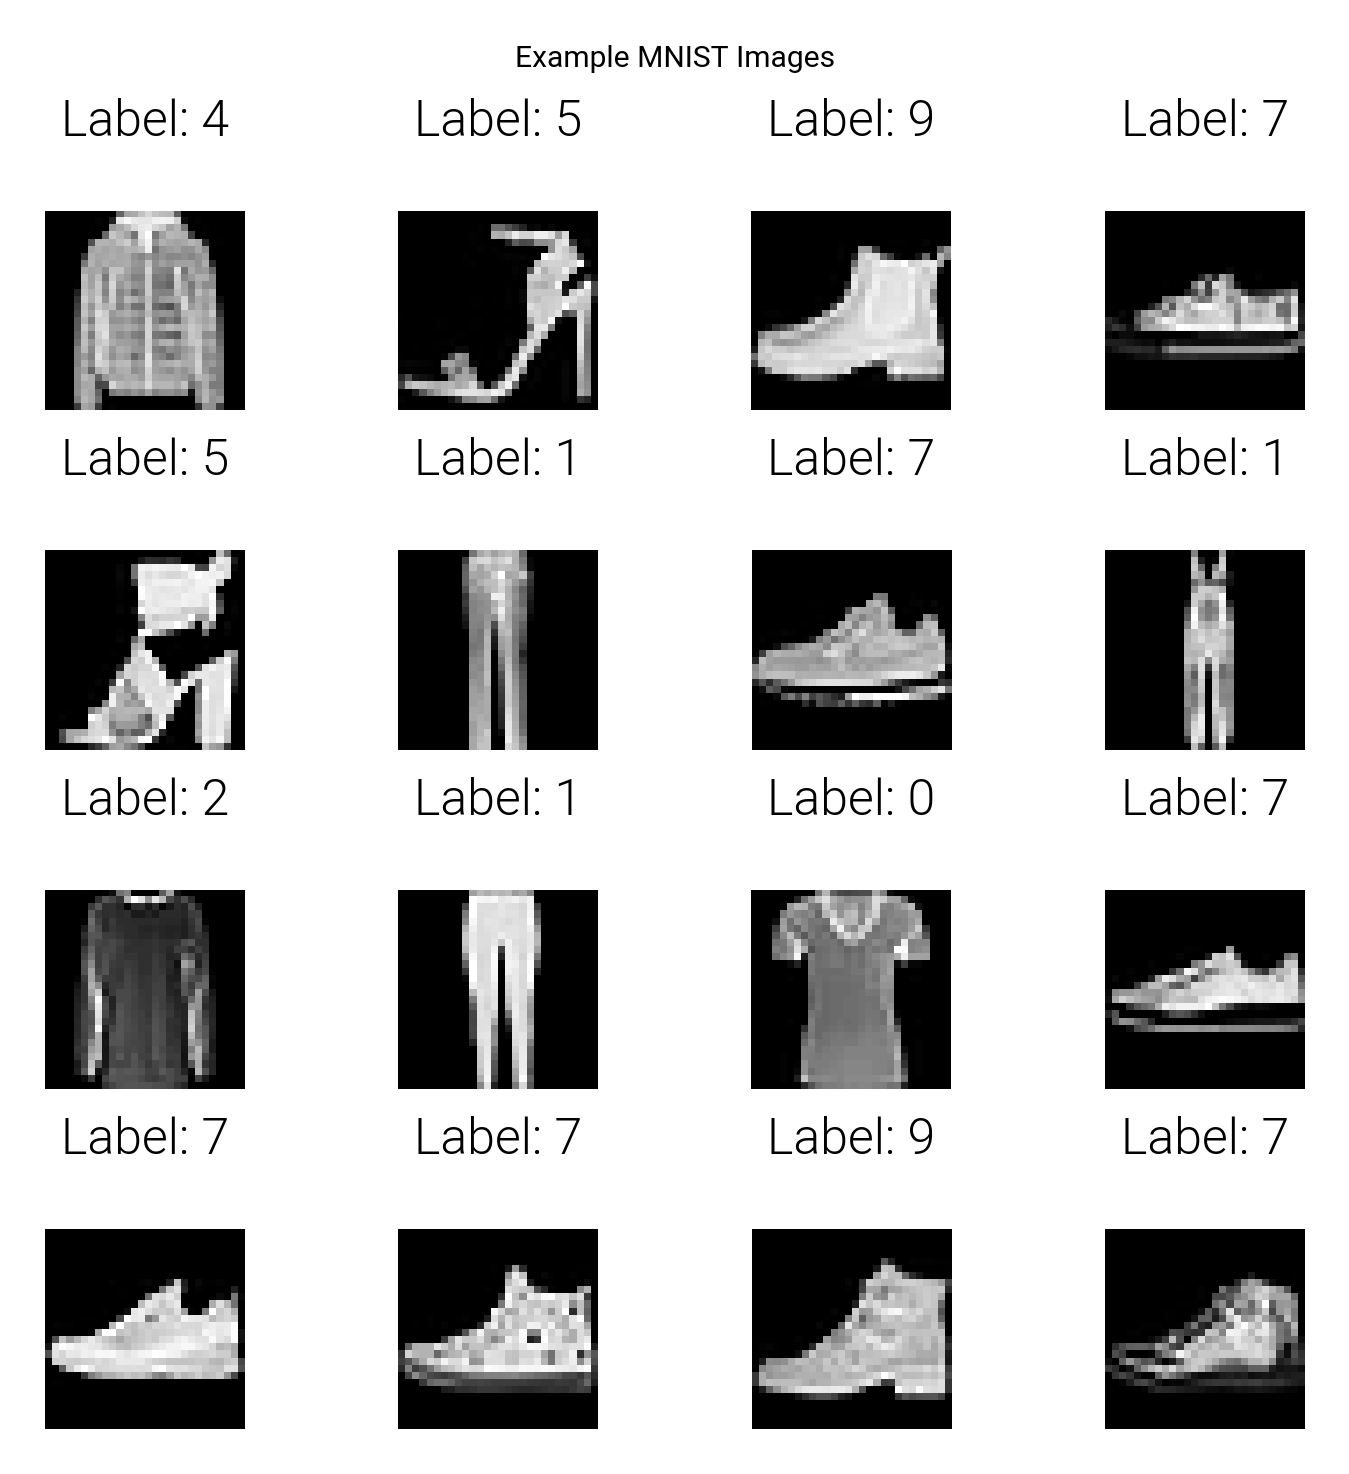

In [88]:
f_data_train = datasets.FashionMNIST('datasets', train=True, download=True, transform=transform)

# Instantiate the training and testing data loaders
f_train_dataloader = DataLoader(f_data_train, shuffle=True, batch_size=256)

plot_sample_images(f_train_dataloader, gridsize=4)

In [ ]:
scores = []
for k, model in models.items():
    with torch.no_grad():
        for loader in [train_dataloader, test_dataloader, f_train_dataloader]:
            for inputs, labels in loader:
                images = inputs['images'].view(BS, 1, -1).to(device)
                labels = labels.view(BS).to(device)
                log_probs = model(images=images, labels=labels)['image_log_probs']
                

# Taking it a step further


In earlier notebooks we learned about region graphs that are better for images.
We also learned about SoS and PICs.
Can you improve on the models above?